Nama         : Ghozy Ghulamul Afif

NIM          : 1301170379

Judul TA     : Implementasi Information Gain (IG) dan Genetic Algorithm (GA) untuk Reduksi Dimensi pada Klasifikasi Data Microarray Menggunakan Functional Link Neural Network (FLNN)

Pembimbing 1 : Widi Astuti, S.T., M.Kom.

Pembimbing 2 : Prof. Dr. Adiwijaya

# 1. Preprocessing

## 1.1. Import Library

In [1]:
import pandas as pd
from sklearn.preprocessing import  MinMaxScaler
from pandas import DataFrame
from scipy.special import legendre
import numpy as np
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from tensorflow.python.keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.python.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
import random
import timeit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

## 1.2. Import Dataset

In [2]:
# data prostate
url_test = "https://raw.githubusercontent.com/jamessaldo/final-task/master/prostate_TumorVSNormal_test.data"
url_train = "https://raw.githubusercontent.com/jamessaldo/final-task/master/prostate_TumorVSNormal_train.data"
data_train = pd.read_csv(url_train, header=None)
data_test = pd.read_csv(url_test, header=None)
data_prostate = data_train.append(data_test, ignore_index = True)

## 1.3. Check Missing Value

In [3]:
print('Total Missing Value pada Data Prostate Tumor:',data_prostate.isnull().sum().sum())

Total Missing Value pada Data Prostate Tumor: 0


## 1.4. Normalization

In [4]:
# Melakukan normalisasi
# data prostate
data_new_prostate = data_prostate.drop([12600],axis=1)
scaler = MinMaxScaler()
data_new_prostate = scaler.fit_transform(data_new_prostate)
data_new_prostate = DataFrame(data_new_prostate)
data_new_prostate['label'] = list(data_prostate[12600])
dic = {'Normal':0,'Tumor':1}
data_new_prostate.replace(dic,inplace=True)

# 2. Define Reusable Function

## Fitness Function

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
def fitness(dataset, orde):
  start = timeit.default_timer()
  X = pd.DataFrame(dataset.iloc[:, 0:len(dataset.columns)-1].values)
  Y = pd.DataFrame(dataset.iloc[:, len(dataset.columns)-1].values)

  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # # Melakukan proses klasifikasi LR
  X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.33, random_state=42)
  # Inisialisasi FLNN
  Model = Sequential()
  # Menambah input layer dan hidden layer pertama
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
  # Menambah hidden layer kedua
  Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu'))
  # Menambah output layer
  Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Menjalankan ANN
  Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
  # Fitting ANN ke training set
  history = Model.fit(X_train, y_train, batch_size = 35, epochs = 100, validation_split = 0.2, verbose=False)

  #Memprediksi hasil test set
  y_pred = Model(X_test)
  y_pred =(y_pred >= 0.5)

  F1 = f1_score(y_test, y_pred, average='macro')

  print("F1 Score : ", F1)

  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return F1

## FLNN Classifier

In [6]:
def FLNN_Classifier(dataset, cancer_name, orde):
  start = timeit.default_timer()
  X = dataset.drop(['label'], axis=1)
  Y = dataset['label']
  df_ = pd.DataFrame()
  for x in range(1, orde+1):
    pn = legendre(x)
    y_orde = pn(X)
    df_ = pd.concat([df_, y_orde], axis=1)
  df_.columns = ["Attribut"+str(i) for i in range(len(df_.columns))]
  df_['label'] = Y.reset_index().label
  data = df_.iloc[:, 0:len(df_.columns)-1].values
  label = df_.iloc[:, len(df_.columns)-1].values

  # Melakukan proses K-Fold
  kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
  kf.get_n_splits(df_)

  # Melakukan proses klasifikasi FLNN
  Hasil_Akurasi = []
  Hasil_F1 = []
  for train_index, test_index in kf.split(X,Y):
    print("Train :" , train_index, "Test :", test_index)
    X_train, X_test, y_train, y_test = data[train_index], data[test_index], label[train_index], label[test_index]
    # Inisialisasi FLNN
    Model = Sequential()
    # Menambah input layer dan hidden layer pertama
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu', input_dim = len(df_.columns)-1))
    # Menambah hidden layer kedua
    Model.add(Dense(units = len(df_.columns)-1, kernel_initializer = 'uniform', activation = 'relu'))
    # Menambah output layer
    Model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    # Menjalankan ANN
    Model.compile(optimizer = Adam(learning_rate=0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    # Fitting ANN ke training set
    history = Model.fit(X_train, y_train, batch_size = 35, epochs = 100, validation_split = 0.2, verbose=False)

    #Memprediksi hasil test set
    y_pred = Model(X_test)
    y_pred =(y_pred >= 0.5)

    #print("X_Train :", X_train)
    print("Y_Train :", y_train)

    #print("X_Test :", X_test)
    print("Y_Test :", y_test)

    hasil = accuracy_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred, average='macro')
    #F1 = f1_score(y_test, y_pred, average)

    print("Akurasi : ", hasil)
    print("F1_Score : ", F1)
    print(classification_report(y_test,y_pred))
    Hasil_Akurasi.append(hasil)
    Hasil_F1.append(F1)

    # Membuat confusion matrix
    from sklearn.metrics import confusion_matrix 
    from mlxtend.plotting import plot_confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(5,5))
    plt.show()

  Akurasi = np.array(Hasil_Akurasi)
  F1_Score = np.array(Hasil_F1)
  avg_akurasi = Akurasi.mean()
  avg_F1 = F1_Score.mean()

  print("avg accuraccy "+cancer_name+" = ",avg_akurasi)
  print("avg F1_Score "+cancer_name+" = ",avg_F1)

  print("max accuraccy "+cancer_name+" = ",Akurasi.max())
  print("max F1_Score "+cancer_name+" = ",F1_Score.max())

  print("min accuraccy "+cancer_name+" = ",Akurasi.min())
  print("min F1_Score "+cancer_name+" = ",F1_Score.min())
  
  stop = timeit.default_timer()
  print('Running Time: ', stop - start) 
  return avg_akurasi, avg_F1

## Genetic Algorithm

In [7]:
# define parameters
mutationRate = 0.1
crossoverRate = 0.8
populationSize = 10
maxGen = 5

def GenerateGene(lengthOfGen):
  genes = [] # menyimpan index feature
  for j in range(lengthOfGen):
    genes.append(random.randint(0,1))
  return genes

def GeneratePopulation(lengthOfGen):
  population = []
  for i in range(populationSize):
    individu = GenerateGene(lengthOfGen)
    population.append(individu)
  return population

def CrossOver(parent_1, parent_2, rate, lengthOfGen): #Random Point Method
  new_pop = [] 
  for i in range((populationSize - 2) // 2):
    if random.random() < rate:
      CP = random.randint(0,lengthOfGen) #CrossPoint
      child = parent_1[0:CP] + parent_2[CP:len(parent_2)]
      new_pop.append(child)
      child = parent_2[0:CP] + parent_1[CP:len(parent_1)]
      new_pop.append(child)
    else:
      new_pop.append(parent_1)
      new_pop.append(parent_2)
  return new_pop

def Mutation(mutant, rate, lengthOfGen):
  for i in range(len(mutant)):
    # memutasi tiap gen yang memiliki kemungkinan < rate(0.1)
    for j in range(lengthOfGen):
      if random.random() <= rate:
        mutant[i][j] = 1 - mutant[i][j]
  return mutant

def ZeroGene(indv): #pengecekan apakah gen isinya kosong atau tidak
  total = 0
  for i in range(len(indv)):
    if indv[i] == 0:
      total += 1
  if len(indv) == total:
    return True
  else:
    return False

def Classification(indv, dataset, orde): #using Entropy as fitness
  datasetGA = pd.DataFrame()
  idxDatasetGA = 0
  for i in range(len(dataset.columns)-1):
    if indv[i] == 1:
      datasetGA[idxDatasetGA] = dataset[i]
      idxDatasetGA += 1
  datasetGA['label'] = dataset['label']
  Acc_score, F1_score = FLNN_Classifier(datasetGA, "Prostate Cancer", orde)
  totalFeatures = idxDatasetGA+1
  return Acc_score, F1_score, totalFeatures

In [8]:
def GeneticAlgorithm(dataset,orde):
  start = timeit.default_timer()
  # Initial Population
  lengthOfGen = len(dataset.columns) - 1 # panjang gene = panjang fitur tanpa label

  # fintess evaluation
  bestF1 = 0
  bestAcc = 0
  bestNFeature = len(dataset.columns) - 1
  best_gene = []
  best_gene_2 = []
  population = GeneratePopulation(lengthOfGen) # Generate 1st Generation
  generation = 0 #max generation = 2**len(feature)

  while (generation < maxGen and (bestF1*100) < 93):
    print('Generation :',generation)
    fitness = pd.DataFrame()
    acc = []
    f1score = []
    # ent = []
    nFeature = []
    gene = []
    i = 0
    while (i < len(population)):
      if ZeroGene(population[i]) == False:
        print('gene :', population[i])
        accuracy, f1, totalFeatures = Classification(population[i], dataset, orde) # Count Fitness Value
        acc.append(accuracy)
        f1score.append(f1)
        nFeature.append(totalFeatures)
        gene.append(population[i])
      i += 1

    fitness['gene'] = gene
    fitness['feature'] = nFeature
    fitness['f1_score'] = f1score
    fitness['accuracy'] = acc

    fitness = fitness.sort_values(['f1_score'],ascending=False)
    
    last_bestF1 = bestF1
    last_bestAcc = bestAcc
    last_bestNFeature = bestNFeature
    last_best_gene = best_gene
    last_best_gene_2 = best_gene_2
    
    if last_bestF1 > fitness['f1_score'][fitness.index[0]]:
        bestF1 = last_bestF1
        bestAcc = last_bestAcc
        bestNFeature = last_bestNFeature
        # select parent
        best_gene = last_best_gene
        best_gene_2 = last_best_gene_2
    else:
        bestF1 = fitness['f1_score'][fitness.index[0]]
        bestAcc = fitness['accuracy'][fitness.index[0]]
        bestNFeature = fitness['feature'][fitness.index[0]]
        # select parent
        best_gene = fitness['gene'][fitness.index[0]].copy()
        best_gene_2 = fitness['gene'][fitness.index[1]].copy()

    #Crossover methods: Fixed Point, "Random Point", Alternate Point
    population = CrossOver(best_gene.copy(), best_gene_2.copy(), crossoverRate, lengthOfGen)

    # Mutation
    population = Mutation(population, mutationRate, lengthOfGen)

    # Masukkan best child tadi
    population.append(best_gene)
    population.append(best_gene_2)

    # Print Result
    print('===============================================================================================================================================================================================================')
    print('gen terbaik :', best_gene)
    print('F-1 Score terbaik :',bestF1,' || Akurasi terbaik :',bestAcc,' || jumlah fitur :',bestNFeature)
    print()

    # New Generation
    generation += 1
  listDrop = []
  for i in range(len(dataset.columns)-1):
    if best_gene[i] == 0:
      listDrop.append(dataset.columns[i])
  dataset_GA = dataset.drop(listDrop, axis = 1)
  stop = timeit.default_timer()
  print('Running Time: ', stop - start)
  return dataset_GA


>
/
Name
Last Modified

# 3. Feature Selection with IG

## Prostate

In [9]:
data_X = data_new_prostate.drop(['label'],axis=1)
data_Y = data_new_prostate['label']

X_train, X_test, Y_train, Y_test = train_test_split(data_X, data_Y, test_size=0.3, random_state=0)

sel_k_best = SelectKBest(mutual_info_classif, k=100)
sel_k_best.fit(data_X, data_Y)
data_X_new = sel_k_best.transform(data_X)

Prostate_IG = pd.DataFrame(data_X_new)
Prostate_IG['label'] = data_Y
useddata_prostate = Prostate_IG
print(useddata_prostate.shape)
Prostate_IG

(136, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.033305,0.064040,0.085265,0.060130,0.078720,0.034029,0.053165,0.030591,0.050074,0.019817,...,0.030769,0.024859,0.049860,0.067010,0.185654,0.030585,0.181395,0.042419,0.041975,1
1,0.000000,0.044543,0.080677,0.072141,0.090349,0.040425,0.052957,0.074895,0.060383,0.007622,...,0.038462,0.015819,0.062478,0.099656,0.181435,0.035239,0.195349,0.079874,0.037037,1
2,0.059351,0.017247,0.082734,0.081604,0.064407,0.012171,0.063368,0.030591,0.058910,0.019055,...,0.056073,0.024294,0.025237,0.066151,0.164557,0.017287,0.181395,0.069043,0.037037,1
3,0.078708,0.015048,0.040259,0.047827,0.059835,0.013413,0.037340,0.030591,0.055965,0.044207,...,0.039069,0.055367,0.028654,0.047251,0.164557,0.033245,0.186047,0.044224,0.044444,1
4,0.091944,0.030245,0.087084,0.067628,0.080012,0.035209,0.048723,0.032700,0.066274,0.010671,...,0.044332,0.023729,0.042324,0.096220,0.177215,0.031915,0.200000,0.046480,0.046914,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.613293,0.440034,0.609745,0.644464,0.628864,0.470442,0.476471,0.068565,0.689249,0.595274,...,0.397773,0.307345,0.573870,0.364261,1.000000,0.444814,0.879070,0.167870,0.760494,0
132,0.604042,0.367245,0.523214,0.519182,0.604910,0.402571,0.341755,0.060127,0.637703,0.557165,...,0.358704,0.299435,0.533211,0.283505,0.957806,0.352394,0.753488,0.187274,0.664198,0
133,0.780387,0.395591,0.451554,0.495086,0.643872,0.346560,0.351541,0.089662,0.721649,0.727134,...,0.380567,0.255367,0.510077,0.259450,0.776371,0.628324,0.851163,0.154332,0.837037,0
134,0.888414,0.349848,0.440718,0.510446,0.517543,0.434302,0.369933,0.045359,0.805596,0.523628,...,0.415385,0.442373,0.512180,0.265464,0.565401,0.456117,0.548837,0.141245,0.602469,0


# 4. Classification

## Prostate + IG

Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Akurasi :  0.9642857142857143
F1_Score :  0.9638709677419355
              precision    recall  f1-score   support

           0      

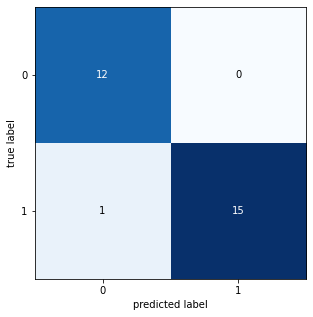

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

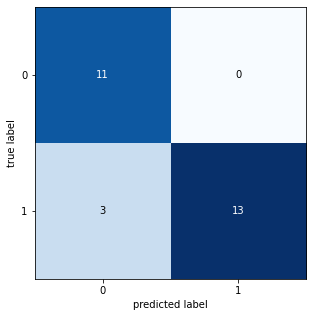

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

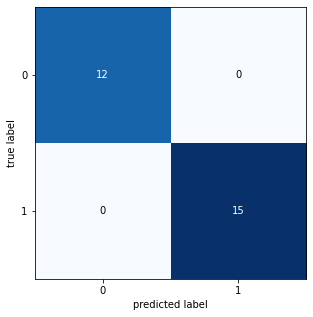

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

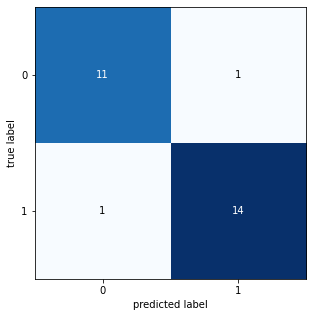

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

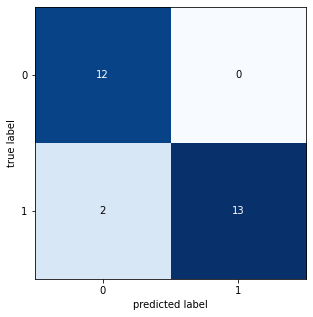

avg accuraccy Prostate cancer =  0.941005291005291
avg F1_Score Prostate cancer =  0.9405942011270154
max accuraccy Prostate cancer =  1.0
max F1_Score Prostate cancer =  1.0
min accuraccy Prostate cancer =  0.8888888888888888
min F1_Score Prostate cancer =  0.8882758620689655
Running Time:  31.70752521199995


(0.941005291005291, 0.9405942011270154)

In [10]:
FLNN_Classifier(Prostate_IG,"Prostate cancer",2)

Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Akurasi :  0.9642857142857143
F1_Score :  0.9638709677419355
              precision    recall  f1-score   support

           0      

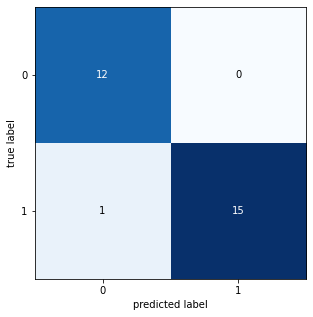

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

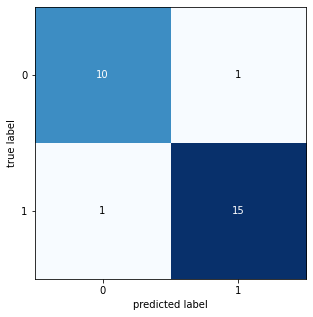

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

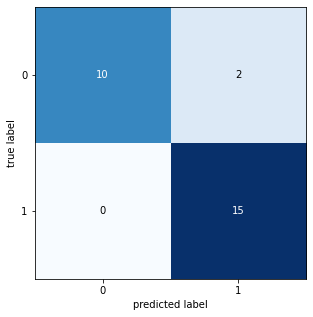

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

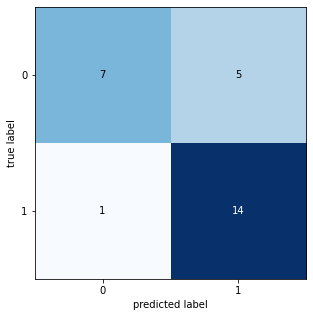

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

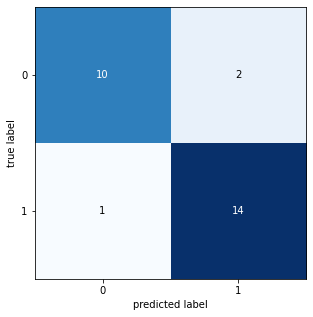

avg accuraccy Prostate cancer =  0.8965608465608466
avg F1_Score Prostate cancer =  0.8917244189273312
max accuraccy Prostate cancer =  0.9642857142857143
max F1_Score Prostate cancer =  0.9638709677419355
min accuraccy Prostate cancer =  0.7777777777777778
min F1_Score Prostate cancer =  0.7617647058823529
Running Time:  31.539902767


(0.8965608465608466, 0.8917244189273312)

In [11]:
FLNN_Classifier(Prostate_IG,"Prostate cancer",3)

Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     

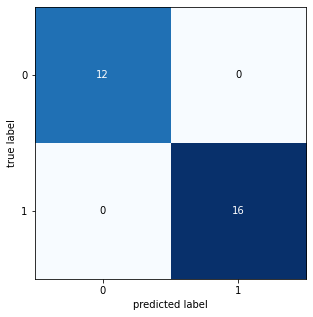

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8499999999999999
              precision    recall  f1-score   support

           0     

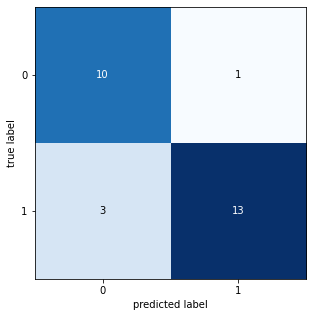

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168831
              precision    recall  f1-score   support

           0     

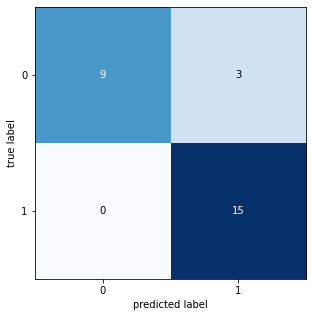

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

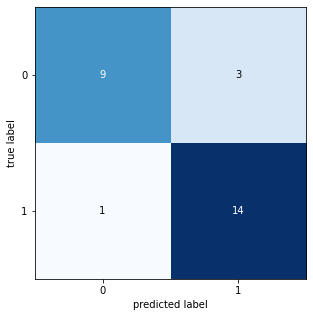

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

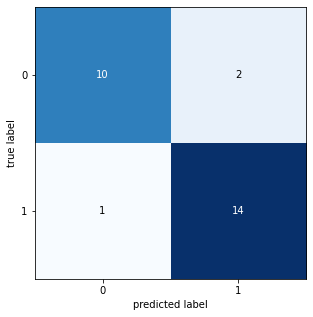

avg accuraccy Prostate cancer =  0.8962962962962961
avg F1_Score Prostate cancer =  0.8932206608258502
max accuraccy Prostate cancer =  1.0
max F1_Score Prostate cancer =  1.0
min accuraccy Prostate cancer =  0.8518518518518519
min F1_Score Prostate cancer =  0.8465909090909091
Running Time:  32.33913335099999


(0.8962962962962961, 0.8932206608258502)

In [12]:
FLNN_Classifier(Prostate_IG,"Prostate cancer",4)

## Prostate + IG + GA

Generation : 0
gene : [1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 

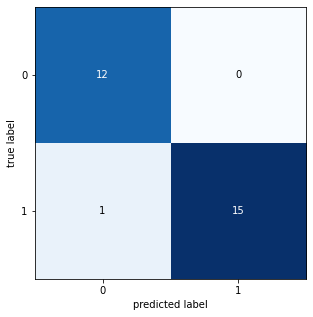

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

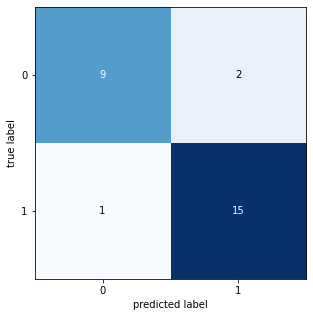

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

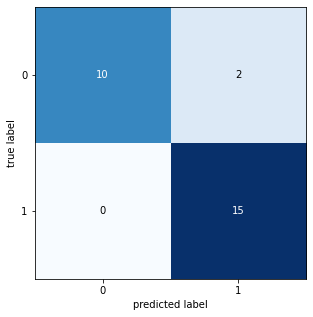

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

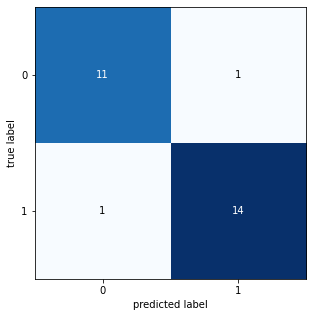

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

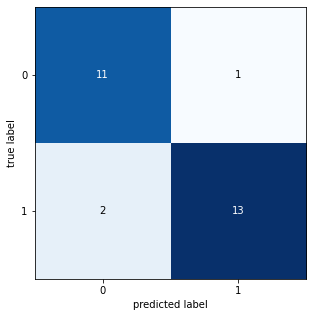

avg accuraccy Prostate Cancer =  0.9187830687830688
avg F1_Score Prostate Cancer =  0.9167118334946478
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8831168831168832
Running Time:  40.870403199000066
gene : [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

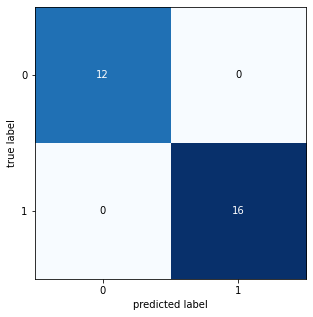

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

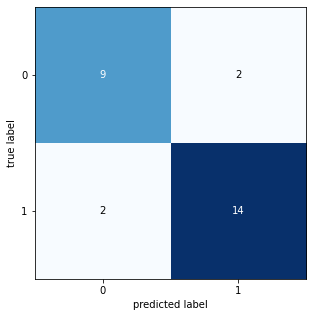

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

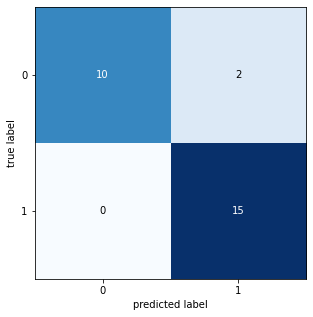

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

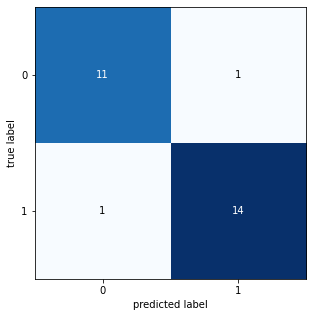

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

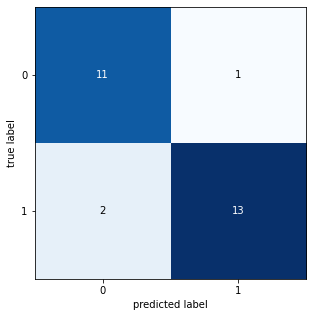

avg accuraccy Prostate Cancer =  0.9185185185185185
avg F1_Score Prostate Cancer =  0.9166324451410659
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909092
Running Time:  40.207991281999966
gene : [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

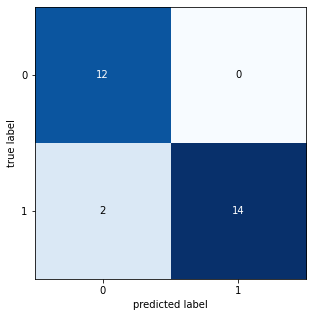

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

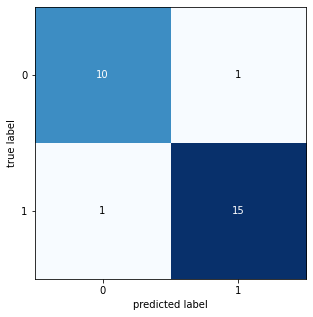

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

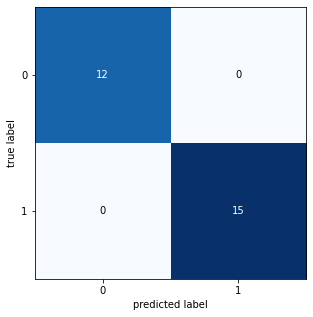

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

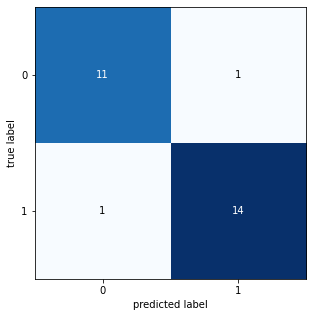

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

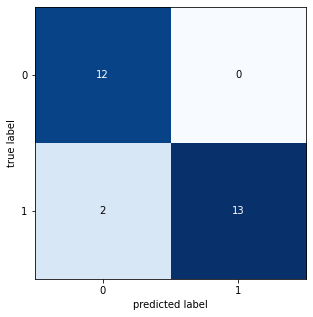

avg accuraccy Prostate Cancer =  0.9412698412698413
avg F1_Score Prostate Cancer =  0.9404649517149517
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.9259259259259259
min F1_Score Prostate Cancer =  0.9232954545454546
Running Time:  40.459747504000006
gene : [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

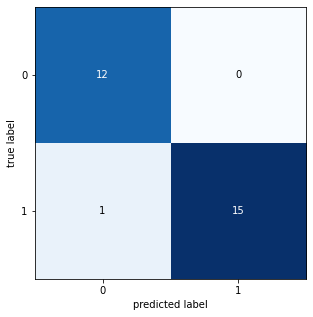

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

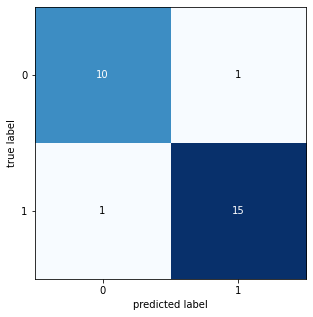

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

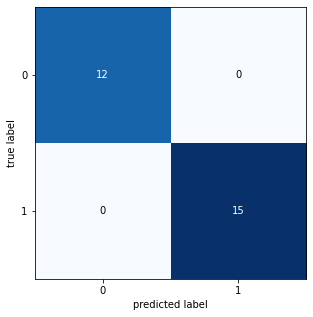

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

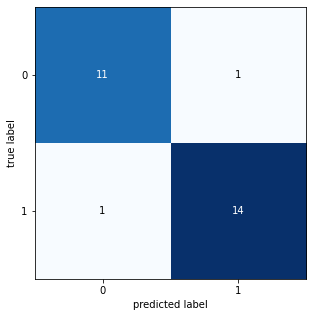

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

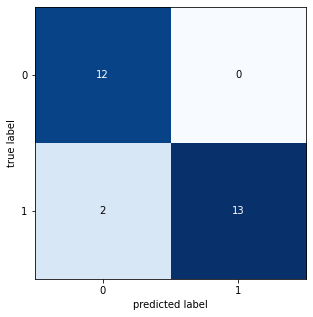

avg accuraccy Prostate Cancer =  0.9484126984126984
avg F1_Score Prostate Cancer =  0.9475981196223133
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.9259259259259259
min F1_Score Prostate Cancer =  0.9232954545454546
Running Time:  40.03671874300005
gene : [1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

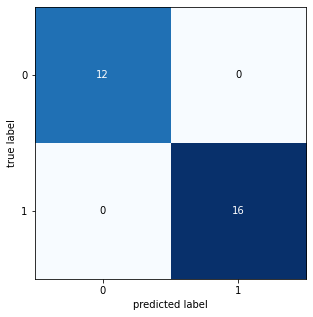

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

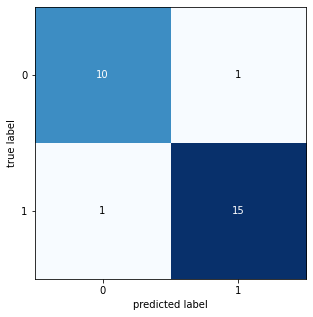

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

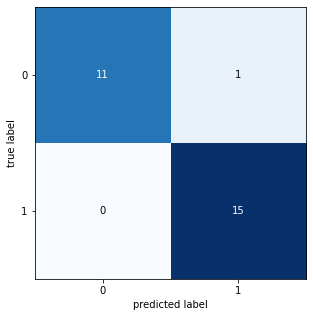

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

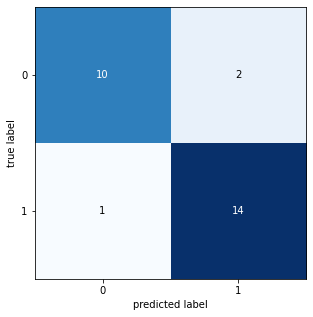

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

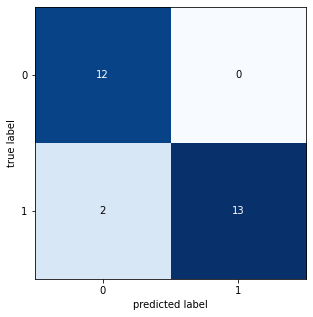

avg accuraccy Prostate Cancer =  0.9407407407407407
avg F1_Score Prostate Cancer =  0.9395293959196485
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8863955119214586
Running Time:  40.728027913999995
gene : [1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

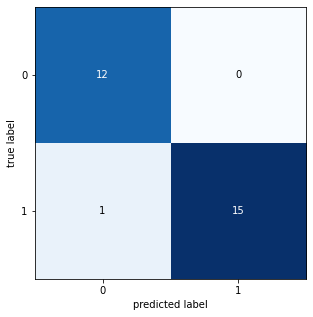

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

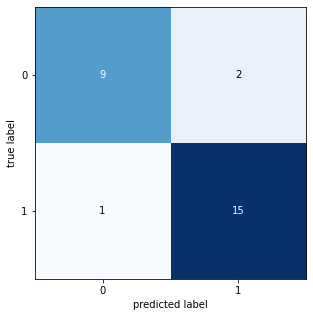

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

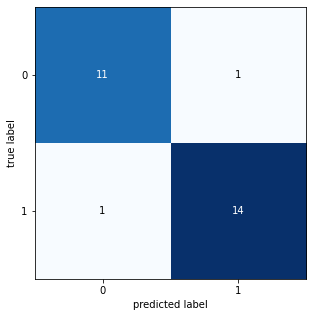

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

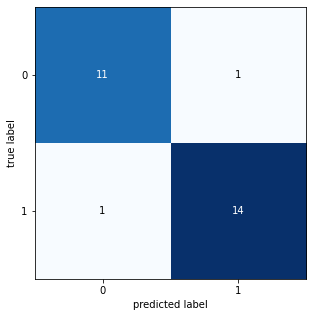

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.888888888888889
              precision    recall  f1-score   support

           0      

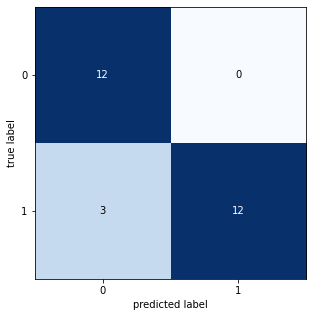

avg accuraccy Prostate Cancer =  0.9187830687830688
avg F1_Score Prostate Cancer =  0.9171753479495417
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8831168831168832
Running Time:  41.037776404000056
gene : [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

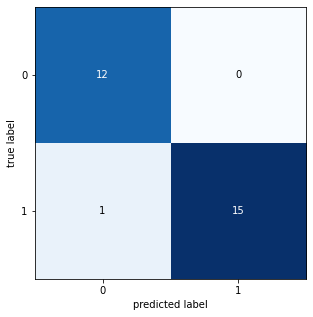

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

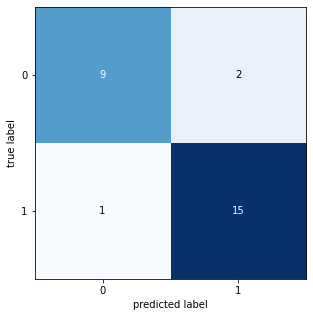

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

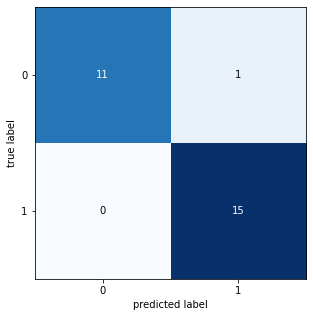

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

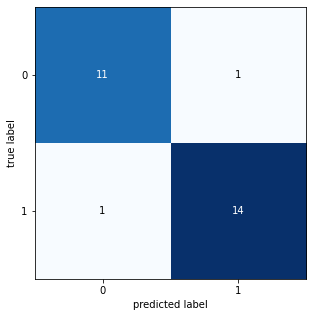

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

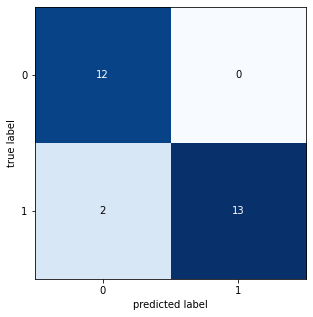

avg accuraccy Prostate Cancer =  0.9335978835978835
avg F1_Score Prostate Cancer =  0.9319887727980296
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8831168831168832
Running Time:  42.233218350000016
gene : [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

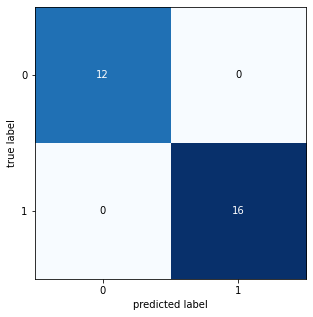

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

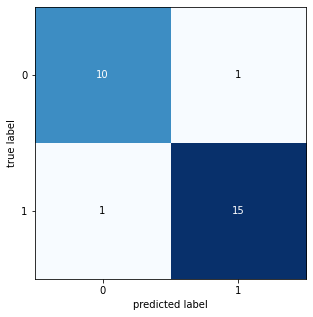

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

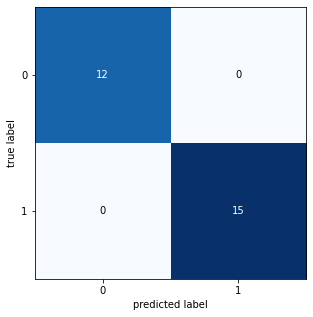

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

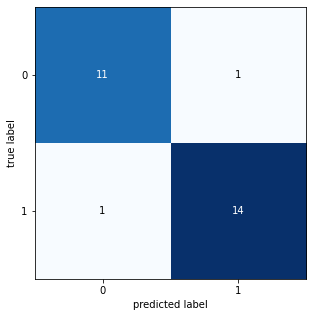

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

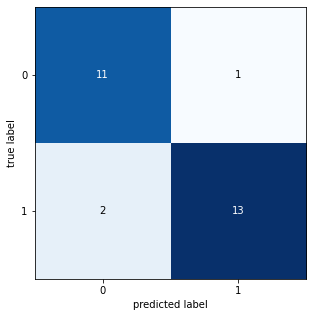

avg accuraccy Prostate Cancer =  0.9481481481481481
avg F1_Score Prostate Cancer =  0.9473142633228842
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8882758620689655
Running Time:  43.68691087100001
gene : [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

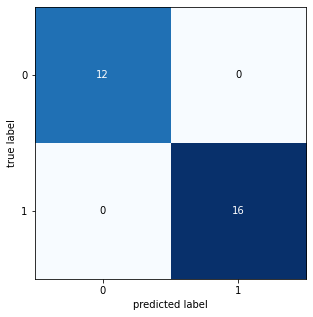

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

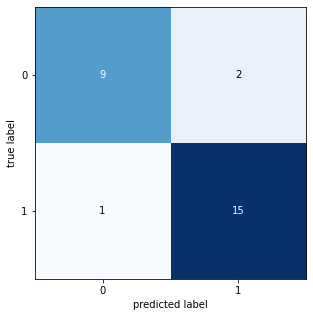

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

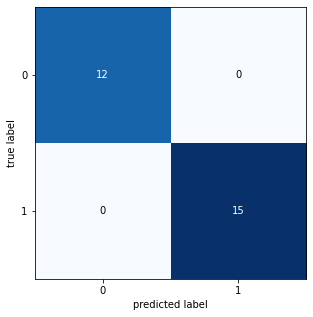

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

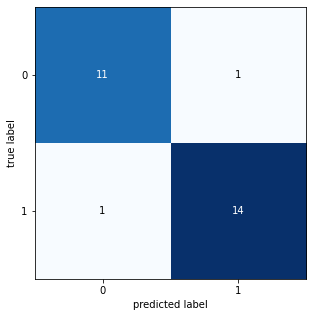

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

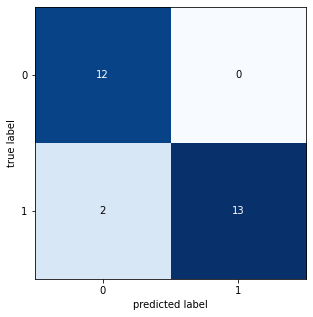

avg accuraccy Prostate Cancer =  0.9481481481481481
avg F1_Score Prostate Cancer =  0.9467882117882118
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8831168831168832
Running Time:  43.040579501000025
gene : [1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

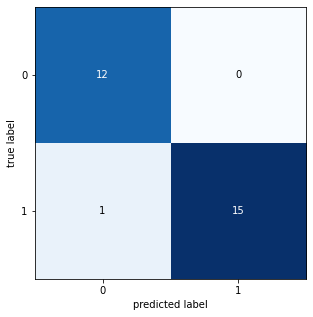

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

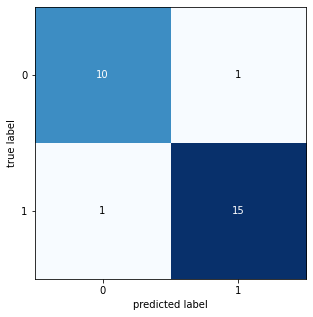

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

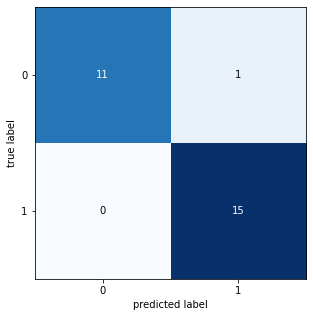

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

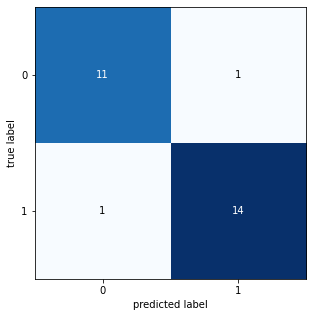

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

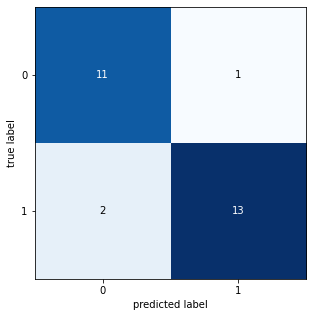

avg accuraccy Prostate Cancer =  0.9335978835978835
avg F1_Score Prostate Cancer =  0.9325148243327017
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8882758620689655
Running Time:  41.63472112900001
gen terbaik : [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0]
F-1 Score terbaik : 0.9475981196223133  || Akurasi terbaik : 0.9484126984126984  || jumlah fitur : 44

Running Time:  414.16049569099994


In [13]:
Prostate_IG_GA = GeneticAlgorithm(Prostate_IG, 2)

Generation : 0
gene : [1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 

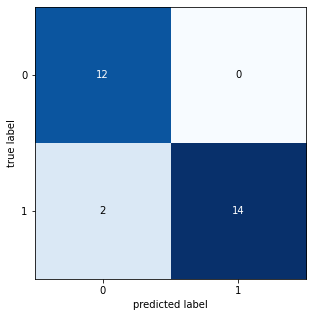

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

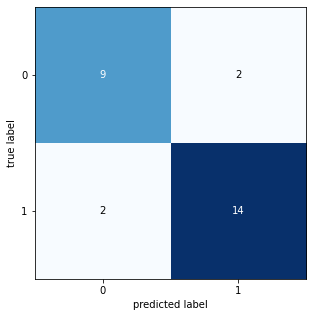

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

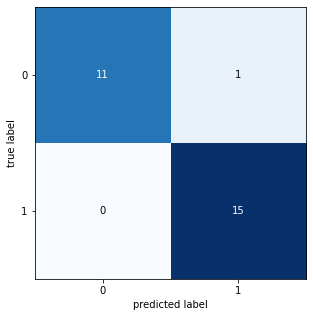

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8106591865357644
              precision    recall  f1-score   support

           0     

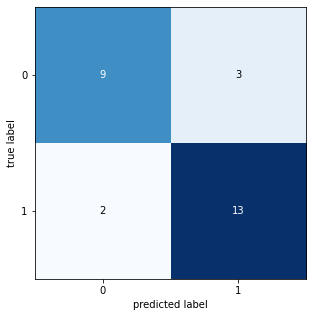

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

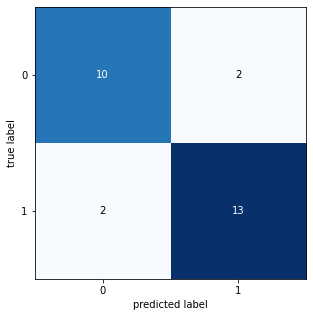

avg accuraccy Prostate Cancer =  0.8820105820105819
avg F1_Score Prostate Cancer =  0.879517412227791
max accuraccy Prostate Cancer =  0.9629629629629629
max F1_Score Prostate Cancer =  0.9621318373071529
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8106591865357644
Running Time:  42.98492829500003
gene : [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

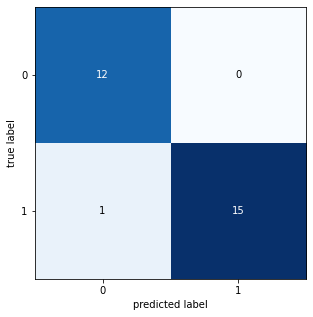

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8411764705882352
              precision    recall  f1-score   support

           0     

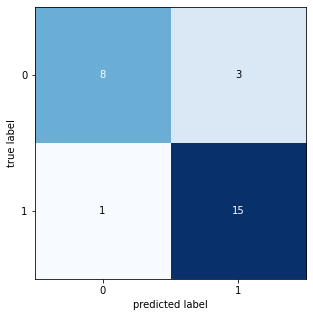

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

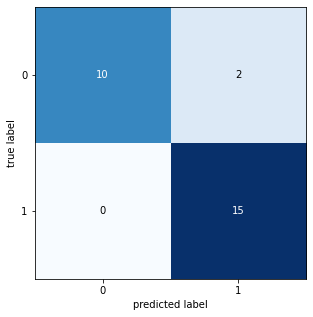

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

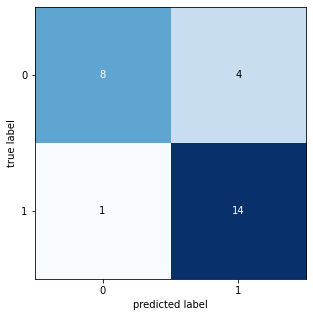

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

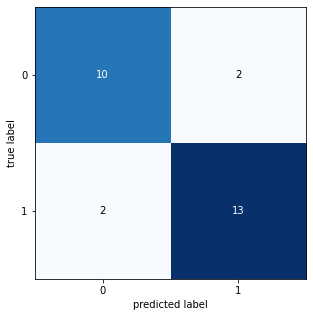

avg accuraccy Prostate Cancer =  0.8817460317460318
avg F1_Score Prostate Cancer =  0.8767075396140861
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  44.33187309799996
gene : [1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

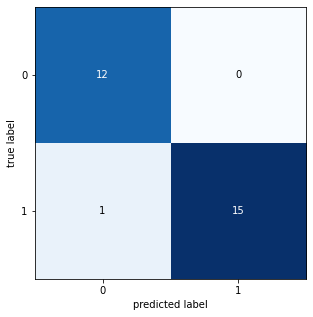

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8781954887218045
              precision    recall  f1-score   support

           0     

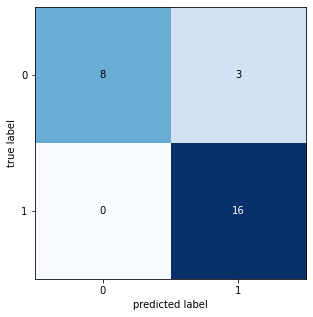

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

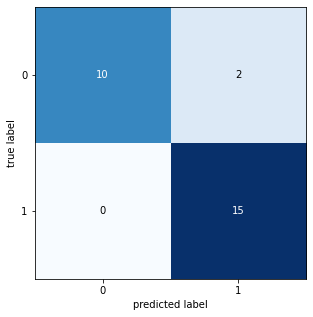

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

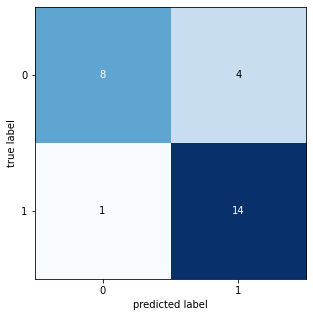

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

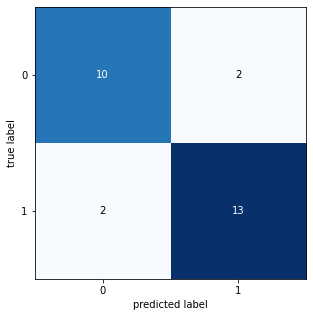

avg accuraccy Prostate Cancer =  0.8891534391534393
avg F1_Score Prostate Cancer =  0.8841113432408001
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  42.43188928299992
gene : [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

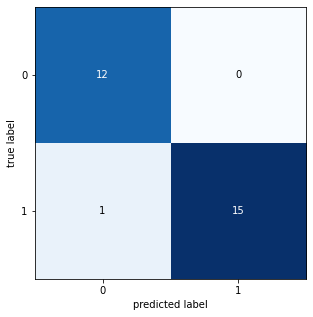

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

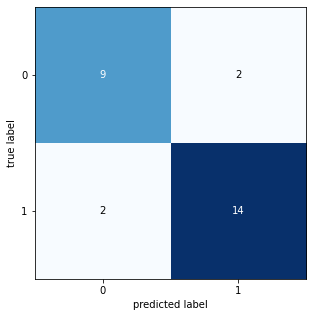

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8411764705882353
              precision    recall  f1-score   support

           0     

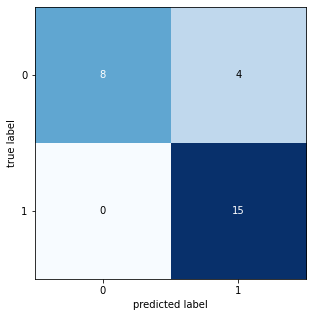

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

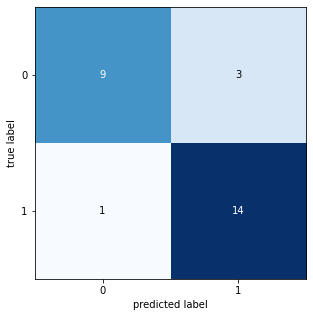

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

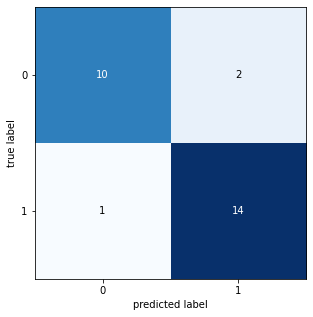

avg accuraccy Prostate Cancer =  0.8817460317460316
avg F1_Score Prostate Cancer =  0.8769249536866897
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8411764705882353
Running Time:  42.21926274799989
gene : [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

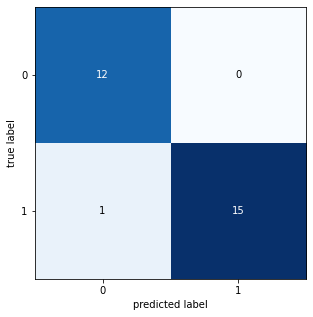

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.85      1

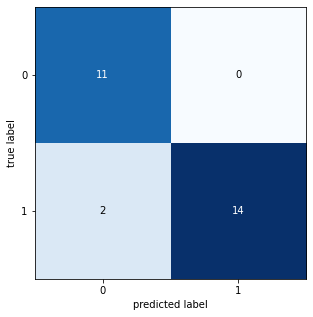

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

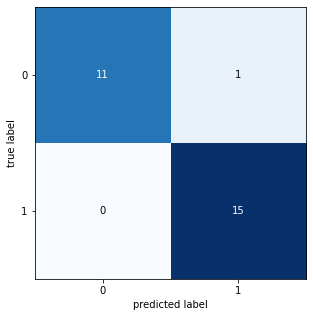

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

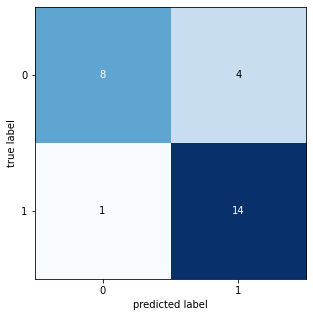

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

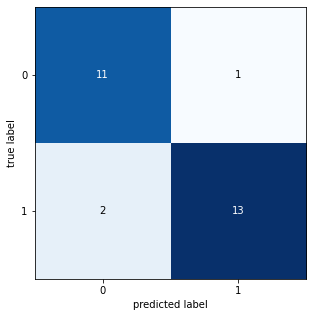

avg accuraccy Prostate Cancer =  0.9113756613756614
avg F1_Score Prostate Cancer =  0.9088946944625718
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  42.367456058000016
gene : [0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

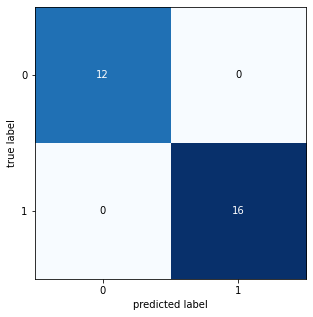

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

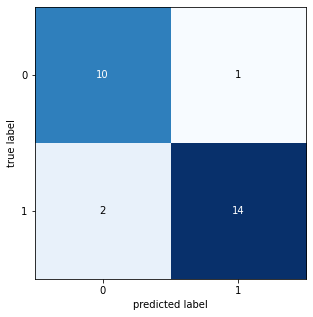

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8411764705882353
              precision    recall  f1-score   support

           0     

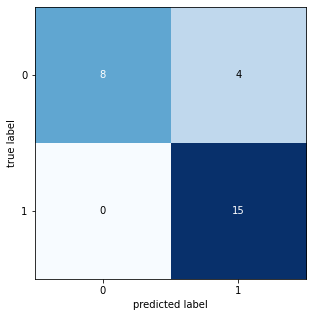

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

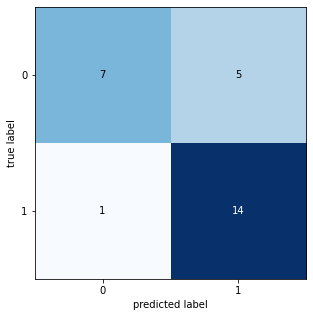

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

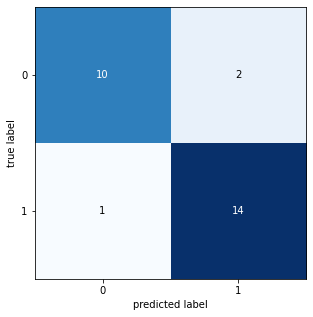

avg accuraccy Prostate Cancer =  0.8814814814814813
avg F1_Score Prostate Cancer =  0.8751464400627011
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7617647058823529
Running Time:  41.92891824200001
gene : [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

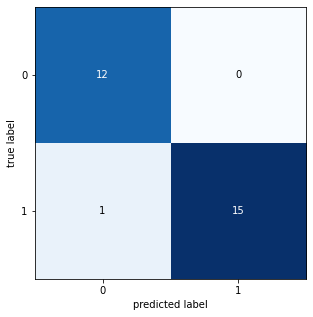

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

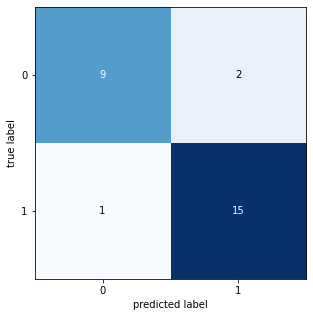

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

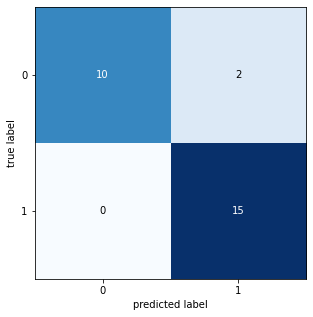

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7407407407407407
F1_Score :  0.7157894736842105
              precision    recall  f1-score   support

           0     

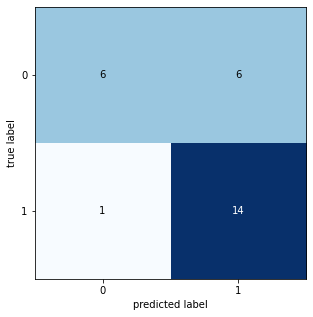

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

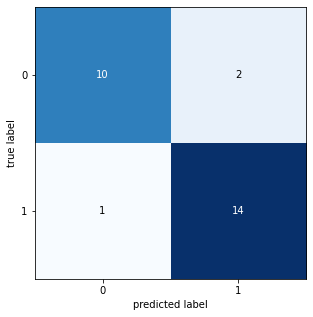

avg accuraccy Prostate Cancer =  0.8817460317460316
avg F1_Score Prostate Cancer =  0.8744936582019885
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7407407407407407
min F1_Score Prostate Cancer =  0.7157894736842105
Running Time:  42.7303527470001
gene : [1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

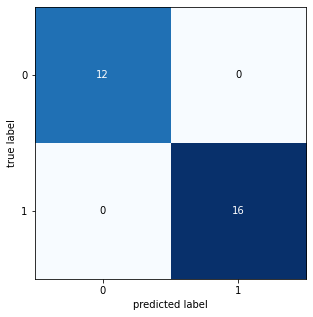

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

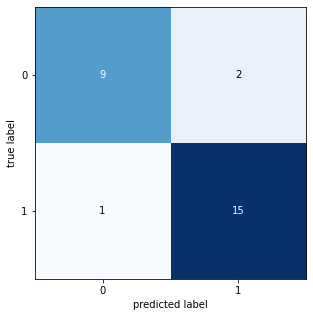

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

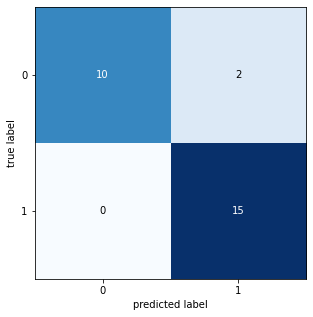

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

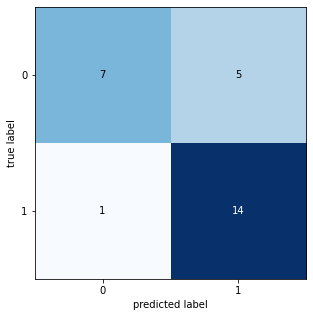

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

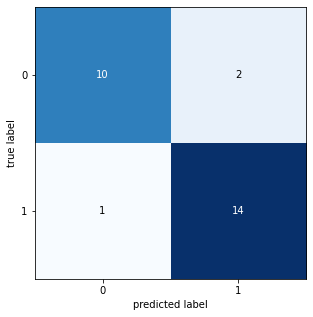

avg accuraccy Prostate Cancer =  0.8962962962962961
avg F1_Score Prostate Cancer =  0.8909145110932298
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7617647058823529
Running Time:  42.3975768759999
gene : [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

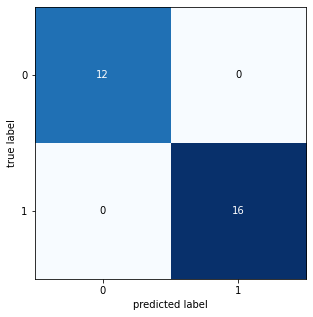

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

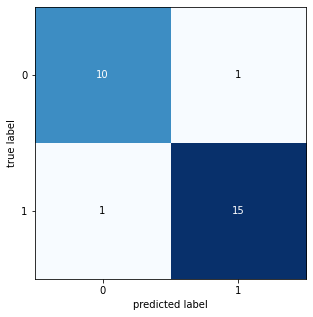

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

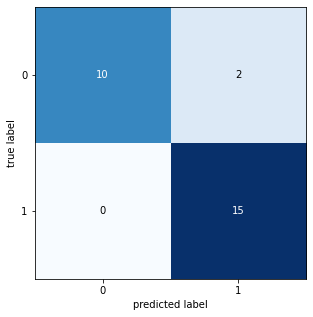

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

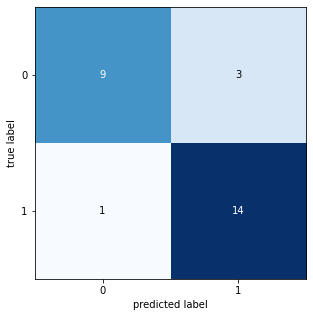

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

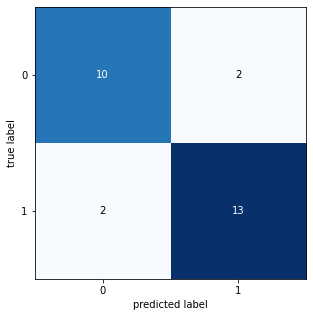

avg accuraccy Prostate Cancer =  0.9111111111111112
avg F1_Score Prostate Cancer =  0.9086363636363636
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909091
Running Time:  42.240185268000005
gene : [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

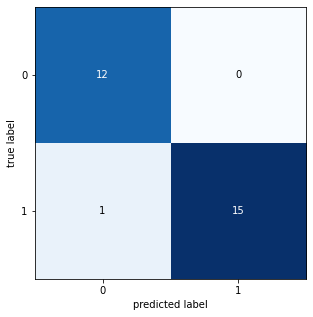

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8148148148148148
F1_Score :  0.7969924812030076
              precision    recall  f1-score   support

           0     

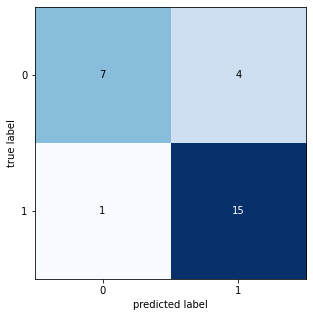

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

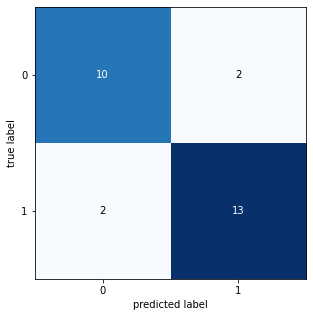

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

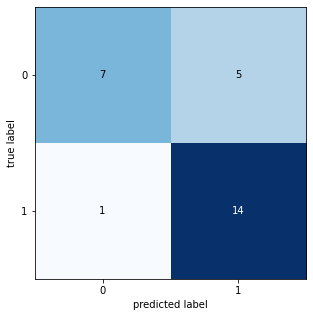

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

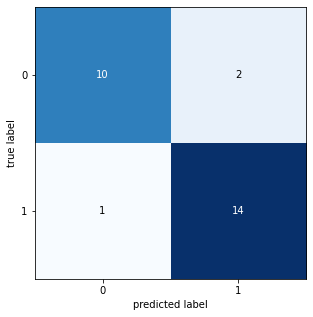

avg accuraccy Prostate Cancer =  0.8595238095238095
avg F1_Score Prostate Cancer =  0.8518047333497509
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7617647058823529
Running Time:  41.991561489000105
gen terbaik : [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]
F-1 Score terbaik : 0.9088946944625718  || Akurasi terbaik : 0.9113756613756614  || jumlah fitur : 54

Generation : 1
gene : [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 

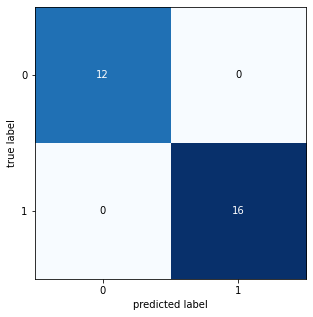

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

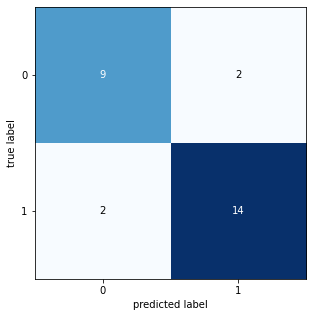

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

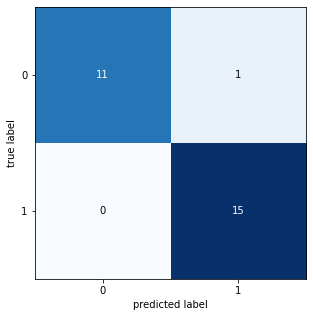

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

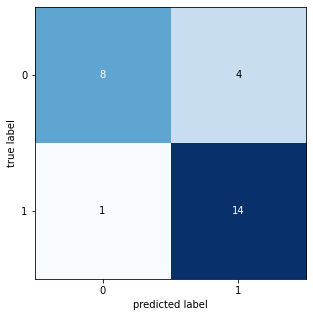

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

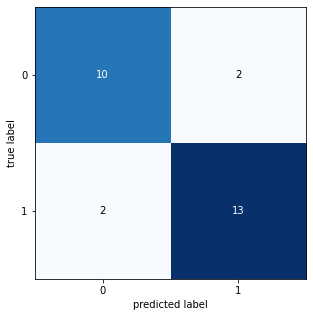

avg accuraccy Prostate Cancer =  0.8962962962962964
avg F1_Score Prostate Cancer =  0.8927835103185735
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  43.04226737199997
gene : [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

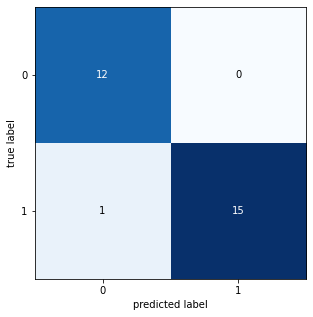

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8411764705882352
              precision    recall  f1-score   support

           0     

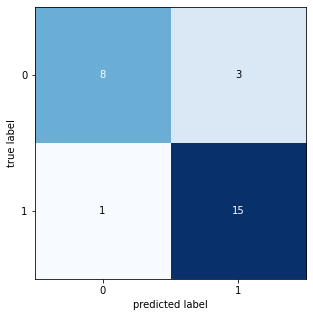

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

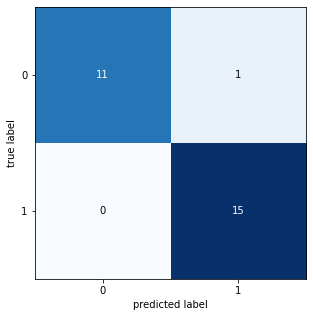

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

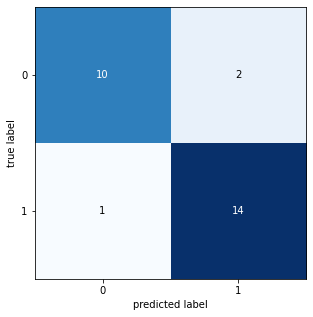

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

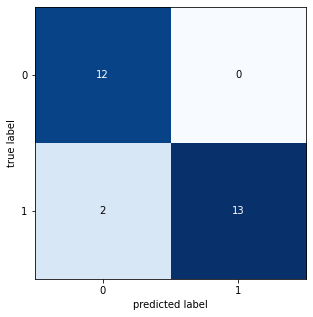

avg accuraccy Prostate Cancer =  0.9187830687830687
avg F1_Score Prostate Cancer =  0.9158797926765917
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8411764705882352
Running Time:  43.24028288000022
gene : [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

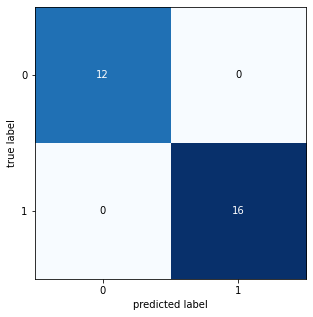

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

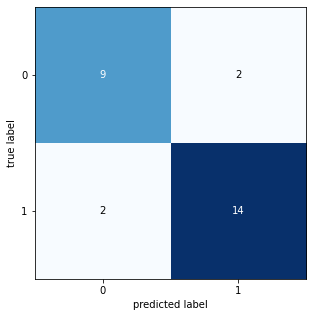

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

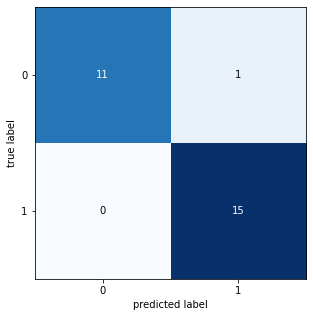

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

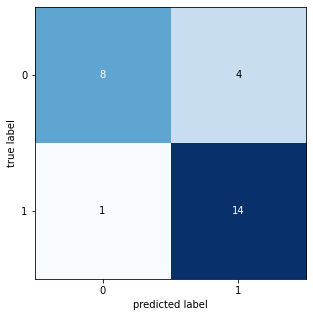

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8137931034482759
              precision    recall  f1-score   support

           0     

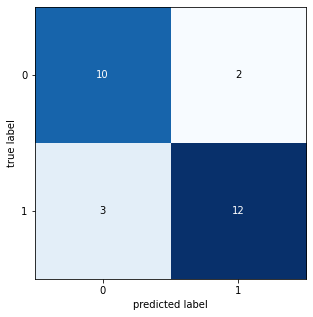

avg accuraccy Prostate Cancer =  0.888888888888889
avg F1_Score Prostate Cancer =  0.8855421310082287
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  48.56420250499991
gene : [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

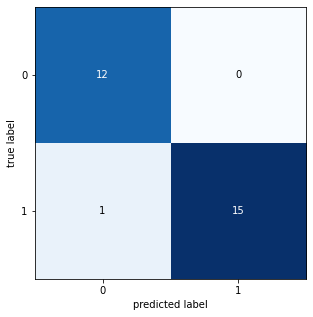

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8411764705882352
              precision    recall  f1-score   support

           0     

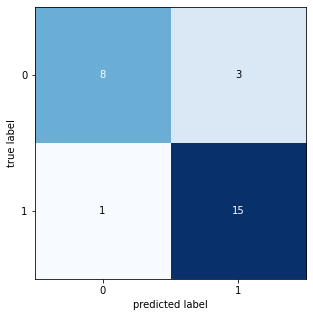

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

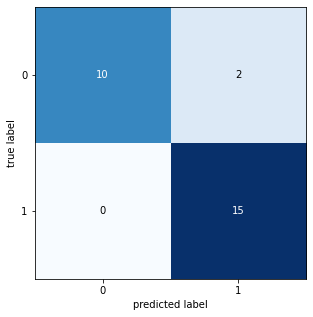

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

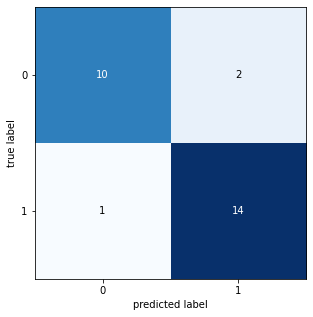

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

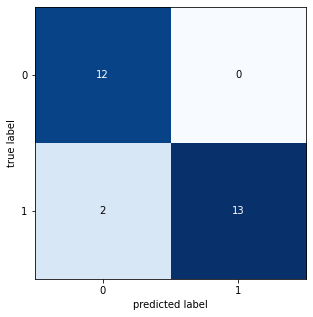

avg accuraccy Prostate Cancer =  0.9113756613756614
avg F1_Score Prostate Cancer =  0.908112516124252
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8411764705882352
Running Time:  46.76659798700007
gene : [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

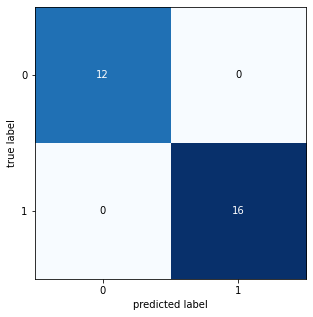

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8499999999999999
              precision    recall  f1-score   support

           0     

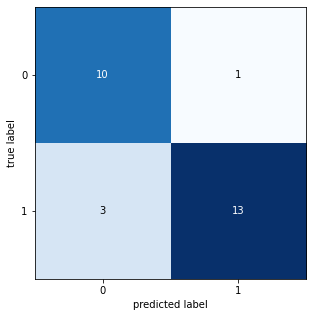

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

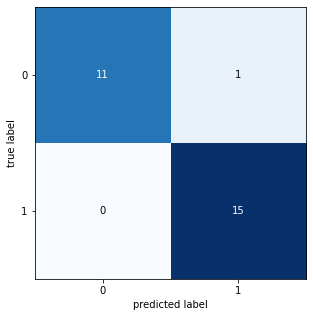

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

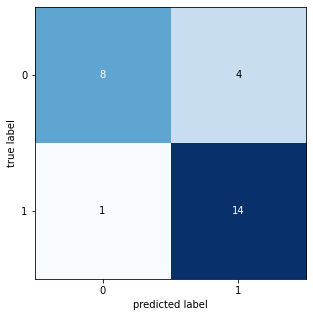

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

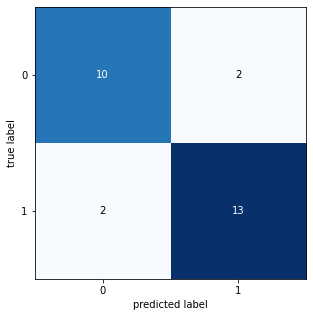

avg accuraccy Prostate Cancer =  0.8962962962962964
avg F1_Score Prostate Cancer =  0.8934653285003916
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  47.65882278999993
gene : [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

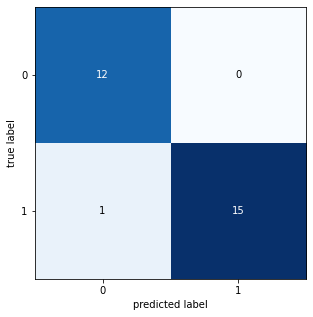

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

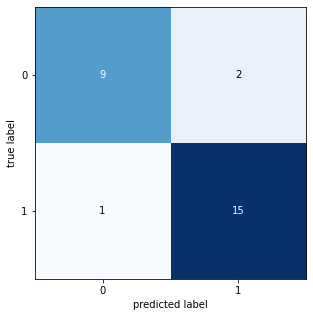

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

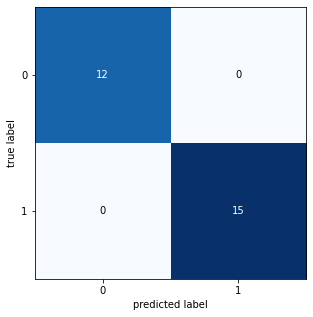

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

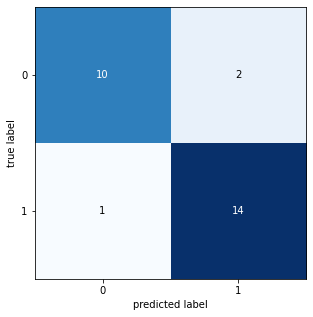

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

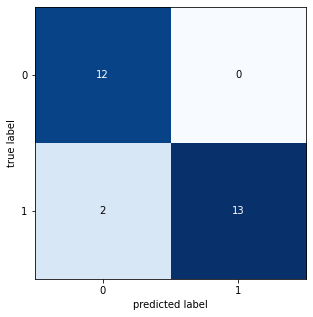

avg accuraccy Prostate Cancer =  0.9335978835978835
avg F1_Score Prostate Cancer =  0.9318415077208906
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8831168831168832
Running Time:  46.6825024100001
gene : [0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

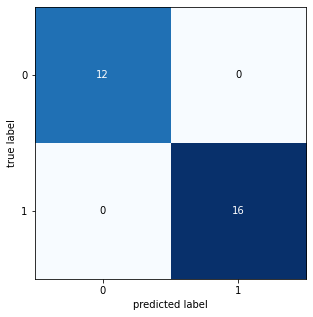

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

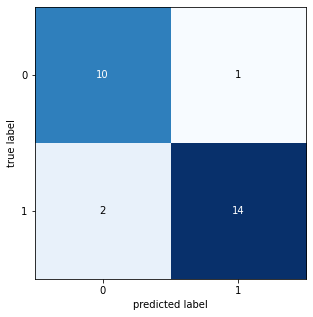

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

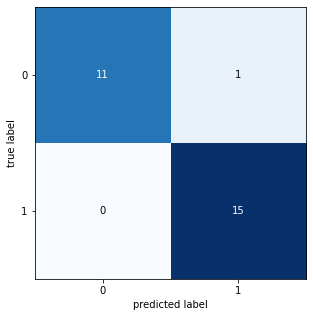

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

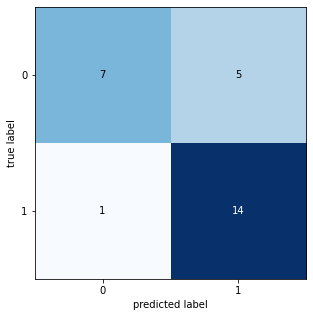

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

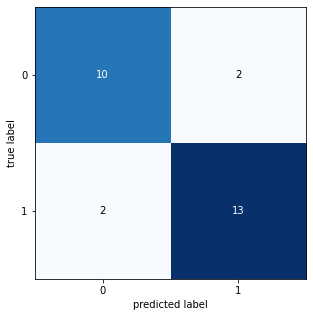

avg accuraccy Prostate Cancer =  0.8962962962962961
avg F1_Score Prostate Cancer =  0.892058411022193
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7617647058823529
Running Time:  47.307234953000034
gene : [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

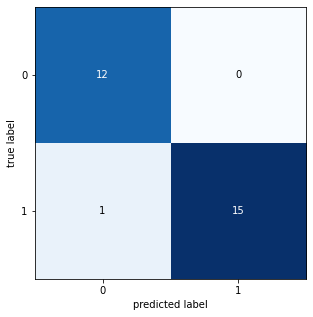

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9629629629629629
F1_Score :  0.961038961038961
              precision    recall  f1-score   support

           0      

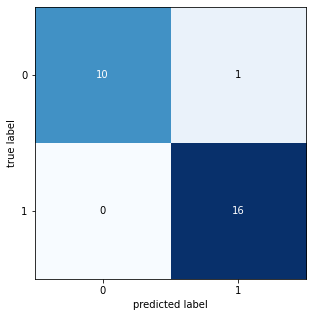

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

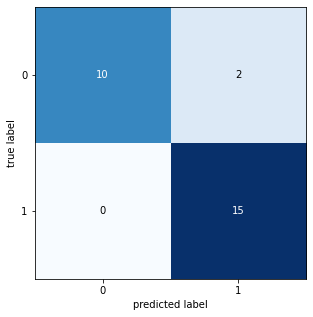

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

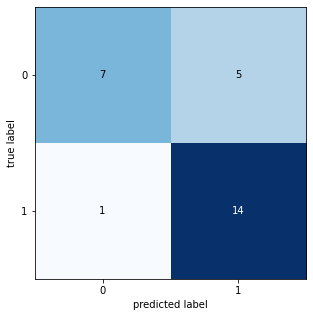

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

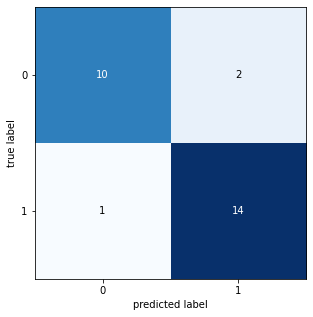

avg accuraccy Prostate Cancer =  0.903968253968254
avg F1_Score Prostate Cancer =  0.8992731202260325
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7617647058823529
Running Time:  46.59104147999983
gene : [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

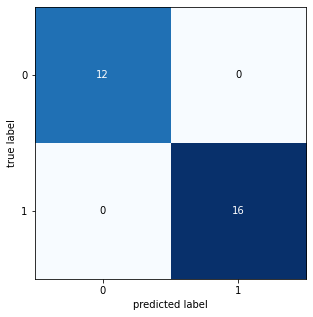

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

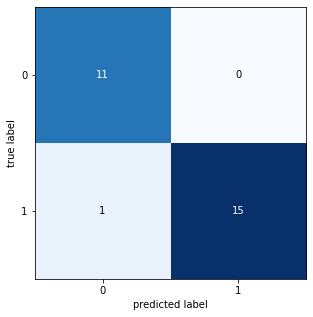

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

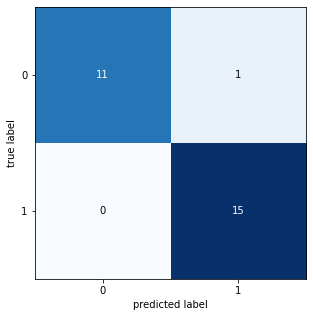

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

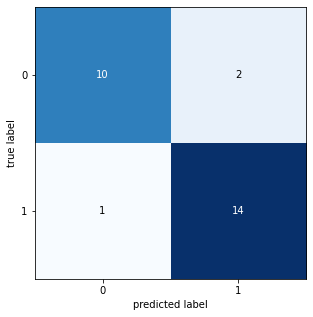

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

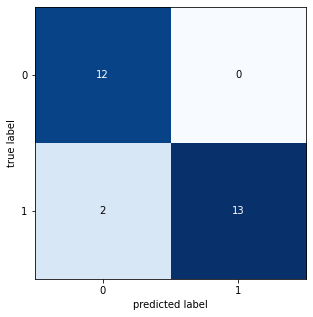

avg accuraccy Prostate Cancer =  0.9481481481481481
avg F1_Score Prostate Cancer =  0.947296672471988
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8863955119214586
Running Time:  51.49765204799996
gene : [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

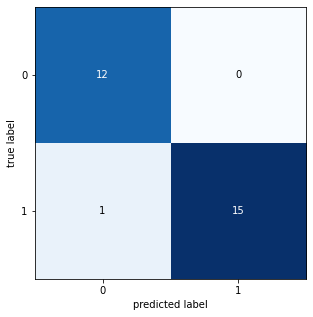

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

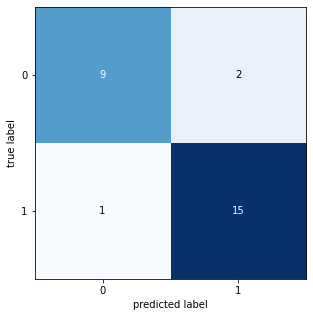

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

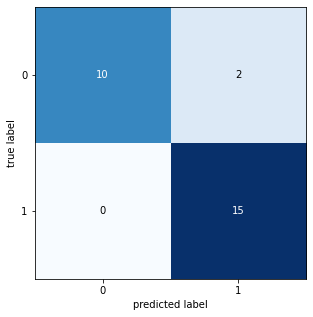

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

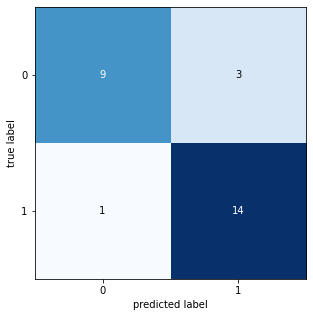

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

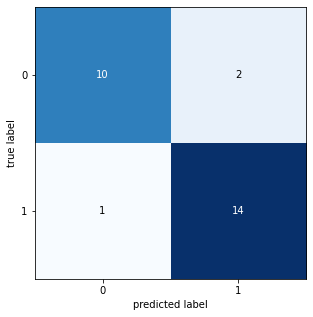

avg accuraccy Prostate Cancer =  0.9039682539682541
avg F1_Score Prostate Cancer =  0.9006539452833282
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909091
Running Time:  53.097357482999996
gen terbaik : [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]
F-1 Score terbaik : 0.947296672471988  || Akurasi terbaik : 0.9481481481481481  || jumlah fitur : 54

Running Time:  900.5086121239999


In [14]:
Prostate_IG_GA = GeneticAlgorithm(Prostate_IG, 3)

Generation : 0
gene : [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 117 118 119 122 123 124 127 128 129 130 131 132 133 134 135] Test : [  1   9  10  14  25  32  44  45  52  53  54  55  59  62  63  66  78  91
  94  96 105 106 110 116 120 121 125 126]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 

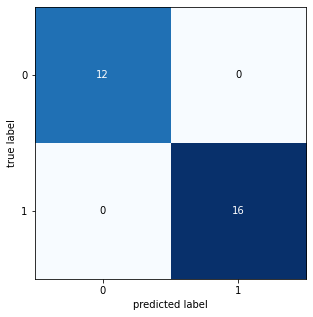

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

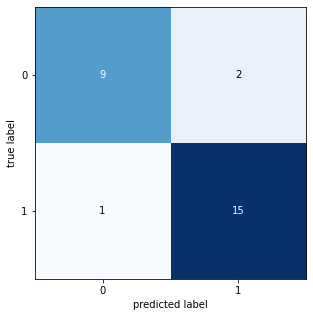

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

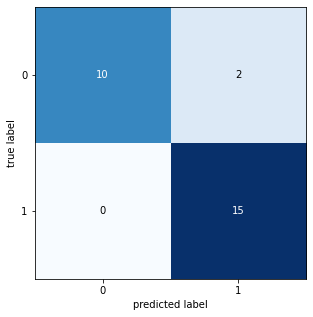

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

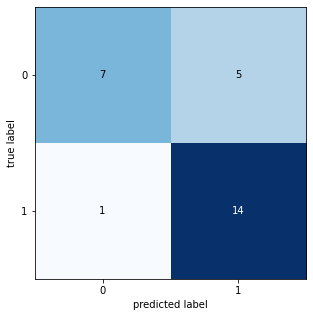

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

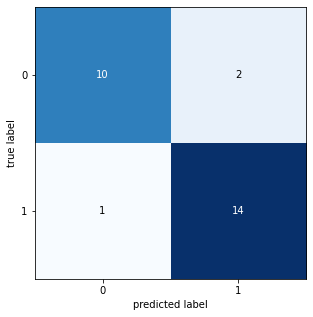

avg accuraccy Prostate Cancer =  0.8962962962962961
avg F1_Score Prostate Cancer =  0.8909145110932298
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7617647058823529
Running Time:  52.52528621600004
gene : [1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

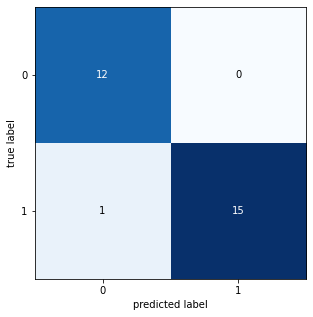

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

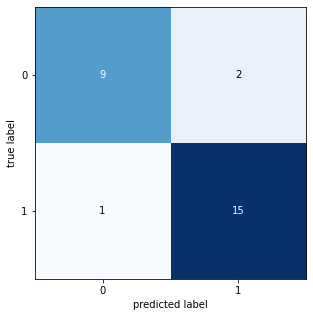

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168831
              precision    recall  f1-score   support

           0     

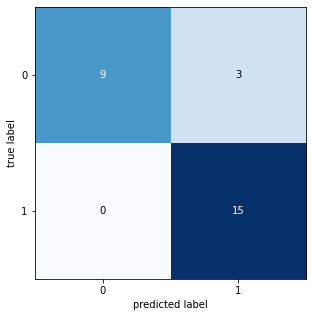

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

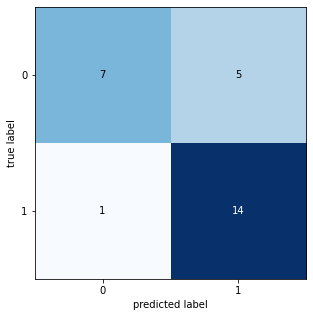

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

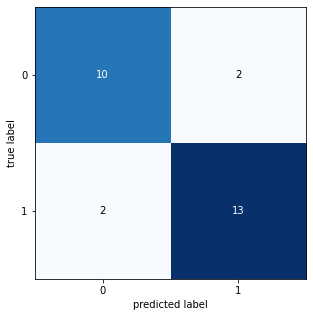

avg accuraccy Prostate Cancer =  0.8743386243386244
avg F1_Score Prostate Cancer =  0.868373887971611
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7617647058823529
Running Time:  46.84474874800003
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

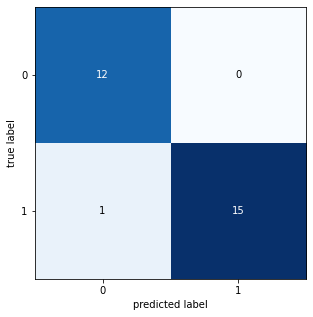

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8411764705882352
              precision    recall  f1-score   support

           0     

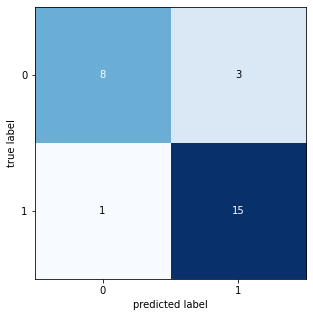

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

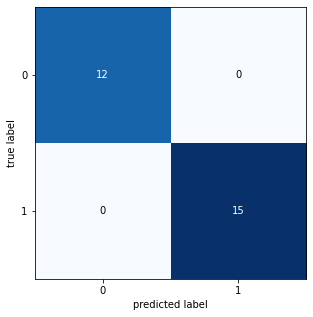

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

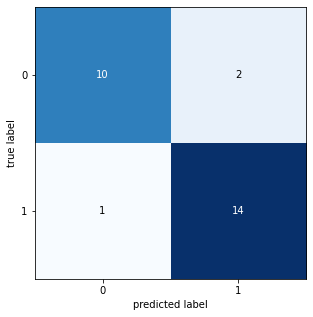

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

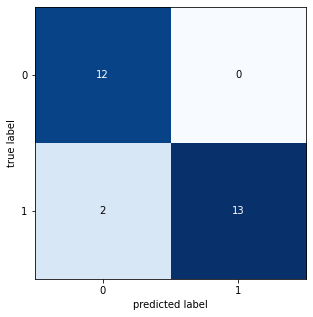

avg accuraccy Prostate Cancer =  0.9261904761904761
avg F1_Score Prostate Cancer =  0.9234534252151609
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8411764705882352
Running Time:  52.225601161999975
gene : [1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

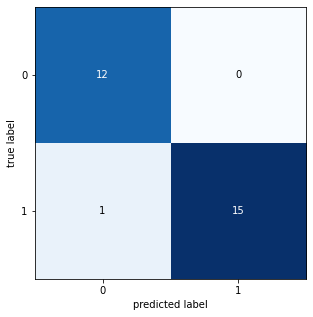

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

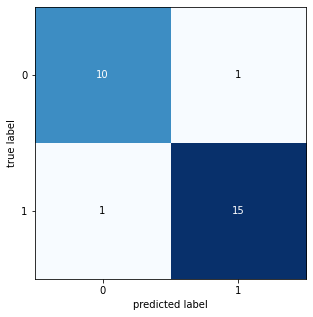

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168831
              precision    recall  f1-score   support

           0     

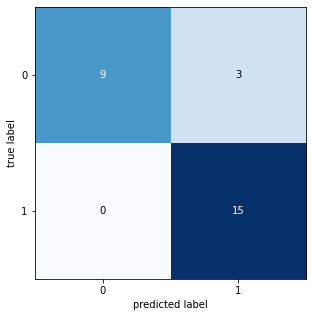

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7037037037037037
F1_Score :  0.6666666666666667
              precision    recall  f1-score   support

           0     

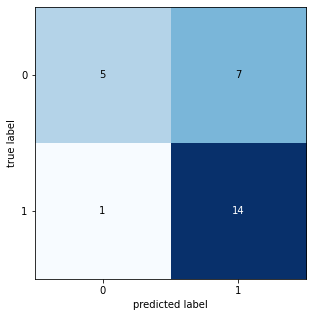

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8137931034482759
              precision    recall  f1-score   support

           0     

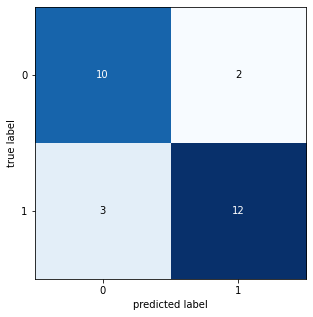

avg accuraccy Prostate Cancer =  0.8595238095238095
avg F1_Score Prostate Cancer =  0.8501486151038431
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7037037037037037
min F1_Score Prostate Cancer =  0.6666666666666667
Running Time:  47.346452019000026
gene : [1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

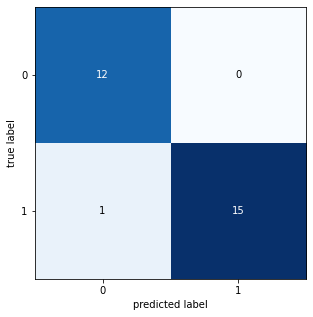

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

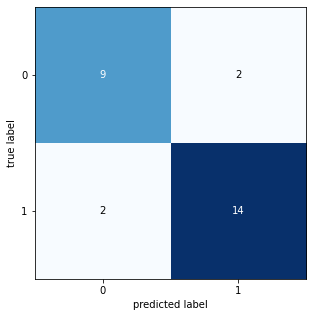

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

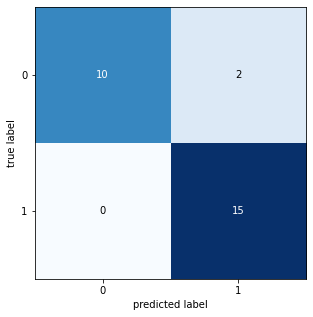

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

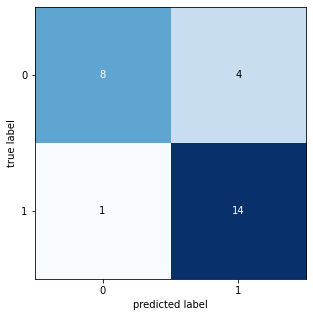

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7698863636363635
              precision    recall  f1-score   support

           0     

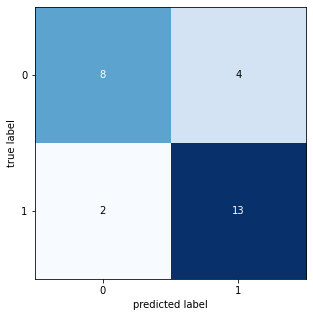

avg accuraccy Prostate Cancer =  0.8669312169312169
avg F1_Score Prostate Cancer =  0.8617677000418936
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7698863636363635
Running Time:  41.448337451999805
gene : [1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

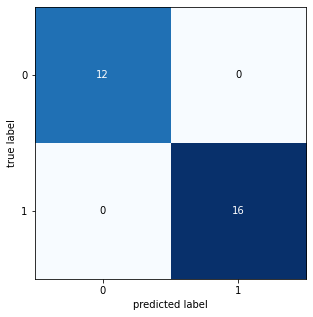

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

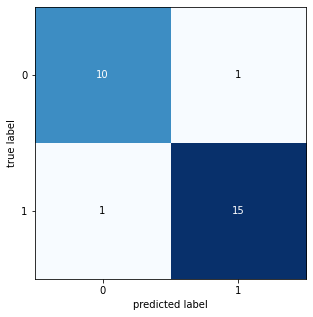

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

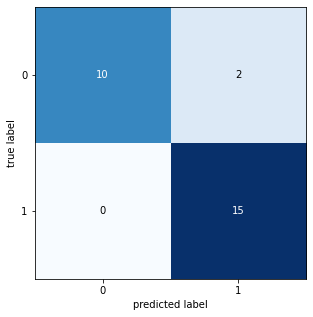

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7407407407407407
F1_Score :  0.7157894736842105
              precision    recall  f1-score   support

           0     

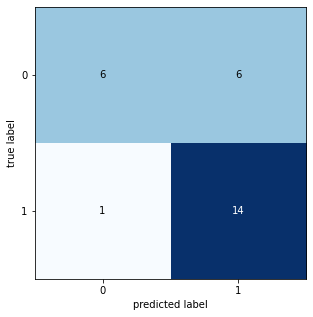

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

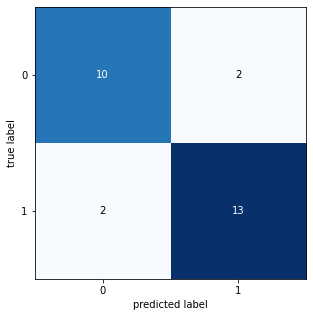

avg accuraccy Prostate Cancer =  0.888888888888889
avg F1_Score Prostate Cancer =  0.8824760765550239
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.7407407407407407
min F1_Score Prostate Cancer =  0.7157894736842105
Running Time:  41.28108794500031
gene : [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

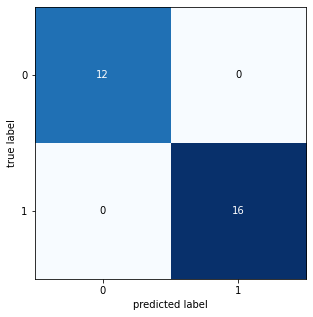

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

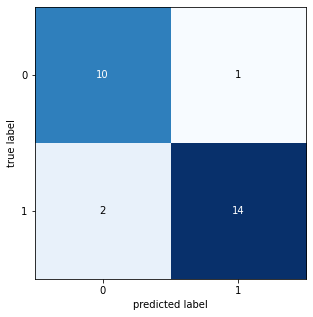

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

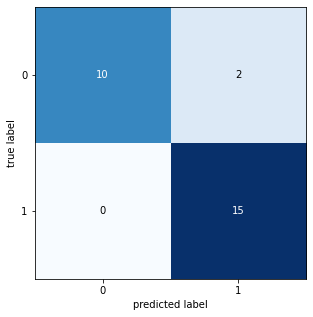

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

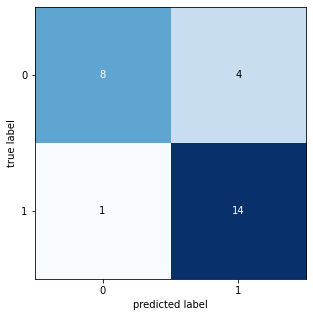

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8137931034482759
              precision    recall  f1-score   support

           0     

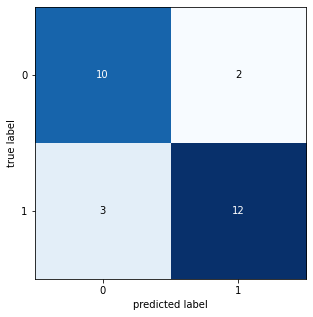

avg accuraccy Prostate Cancer =  0.888888888888889
avg F1_Score Prostate Cancer =  0.885735775021999
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  41.83318009700042
gene : [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 

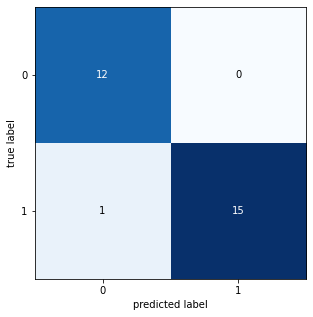

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

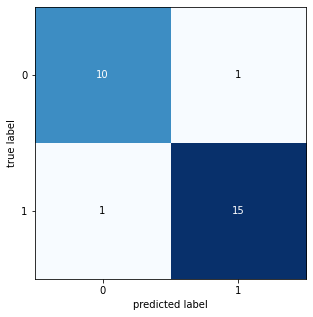

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

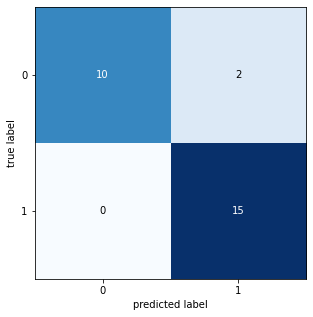

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7037037037037037
F1_Score :  0.6666666666666667
              precision    recall  f1-score   support

           0     

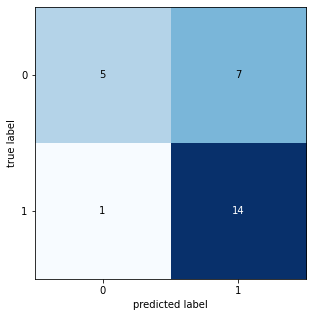

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

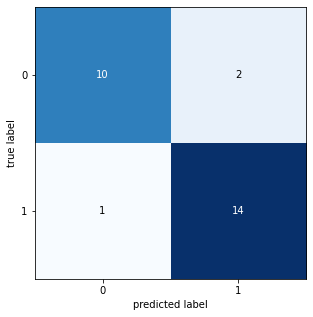

avg accuraccy Prostate Cancer =  0.8817460317460316
avg F1_Score Prostate Cancer =  0.872704811084194
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7037037037037037
min F1_Score Prostate Cancer =  0.6666666666666667
Running Time:  41.11896194499968
gene : [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

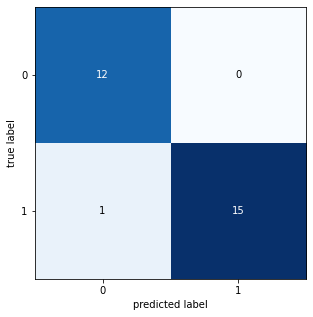

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

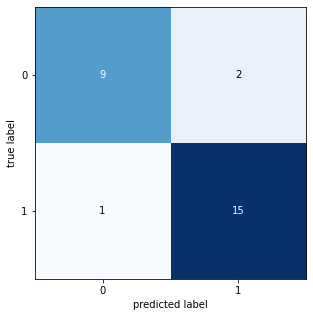

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

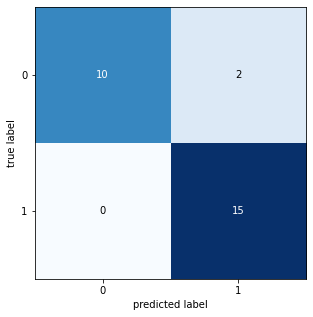

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7037037037037037
F1_Score :  0.6666666666666667
              precision    recall  f1-score   support

           0     

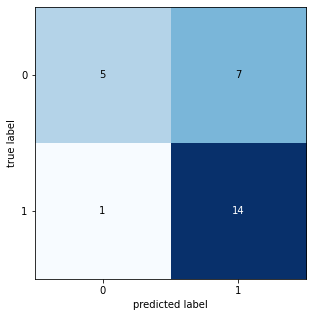

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

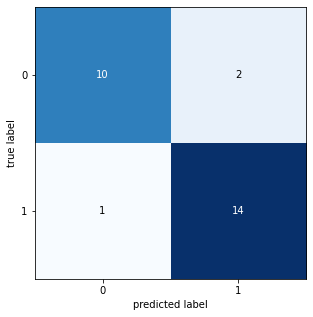

avg accuraccy Prostate Cancer =  0.8743386243386244
avg F1_Score Prostate Cancer =  0.8646690967984798
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7037037037037037
min F1_Score Prostate Cancer =  0.6666666666666667
Running Time:  41.51617989500028
gene : [1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

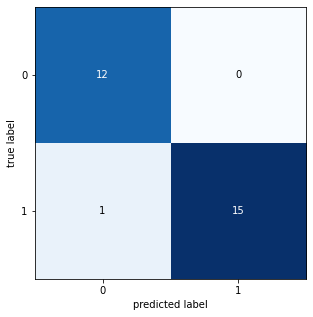

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

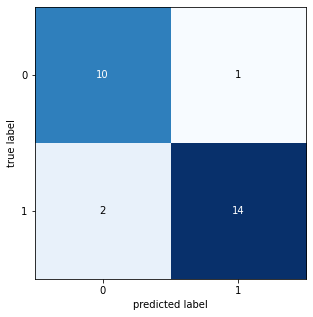

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.7969924812030075
              precision    recall  f1-score   support

           0     

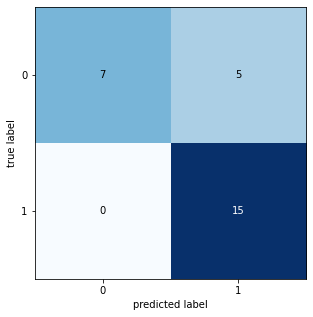

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7037037037037037
F1_Score :  0.6666666666666667
              precision    recall  f1-score   support

           0     

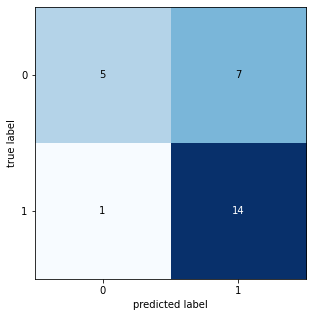

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8106591865357644
              precision    recall  f1-score   support

           0     

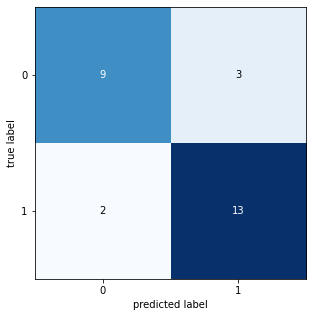

avg accuraccy Prostate Cancer =  0.8373015873015873
avg F1_Score Prostate Cancer =  0.8249169628137665
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7037037037037037
min F1_Score Prostate Cancer =  0.6666666666666667
Running Time:  40.96379525299972
gen terbaik : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
F-1 Score terbaik : 0.9234534252151609  || Akurasi terbaik : 0.9261904761904761  || jumlah fitur : 49

Generation : 1
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0

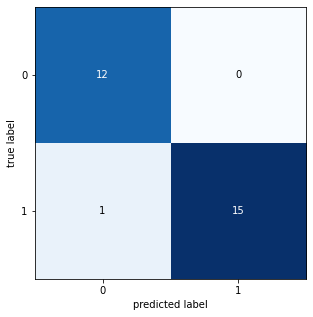

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

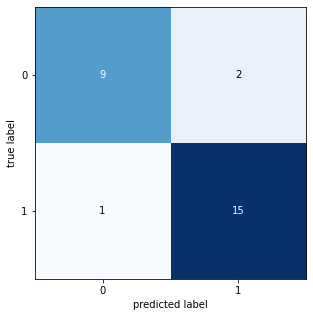

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.7969924812030075
              precision    recall  f1-score   support

           0     

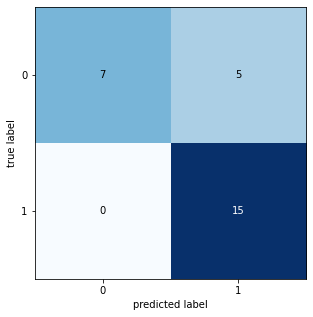

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

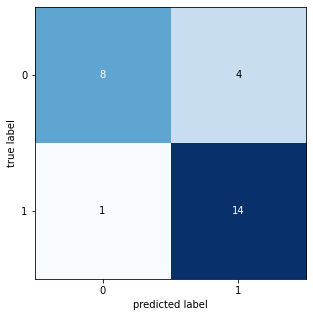

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

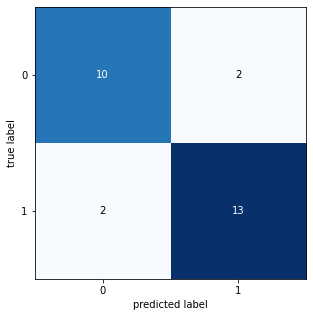

avg accuraccy Prostate Cancer =  0.8669312169312169
avg F1_Score Prostate Cancer =  0.8598350274513262
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.7969924812030075
Running Time:  41.174077972000305
gene : [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

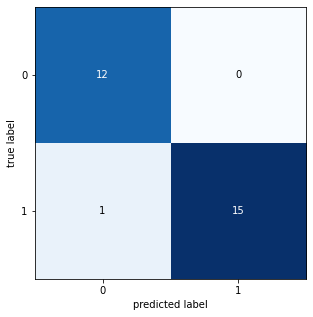

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

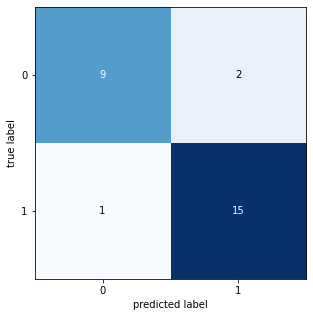

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

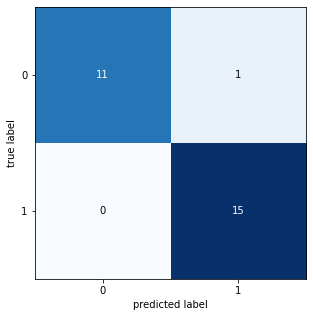

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

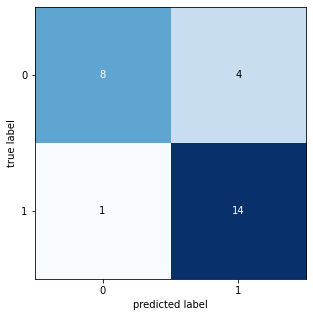

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

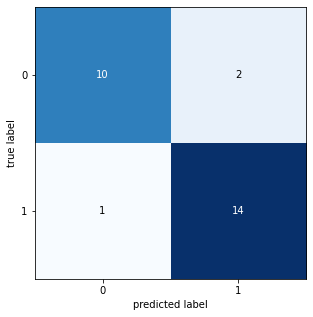

avg accuraccy Prostate Cancer =  0.903968253968254
avg F1_Score Prostate Cancer =  0.9001420010564471
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  41.34520856900008
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

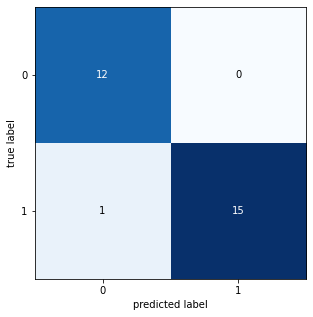

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

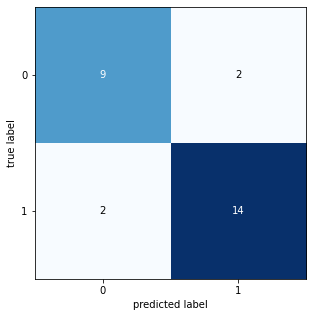

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

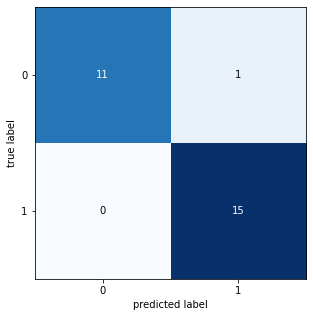

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

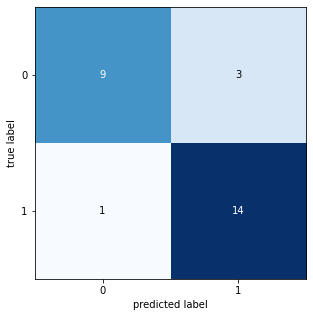

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

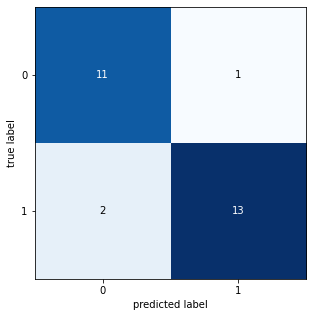

avg accuraccy Prostate Cancer =  0.9039682539682538
avg F1_Score Prostate Cancer =  0.9014920970599745
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909091
Running Time:  43.05472209699974
gene : [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

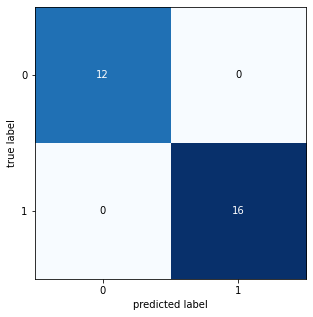

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

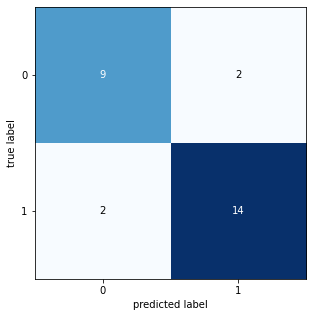

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

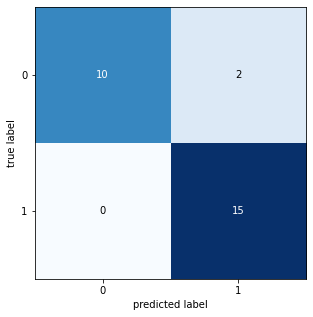

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

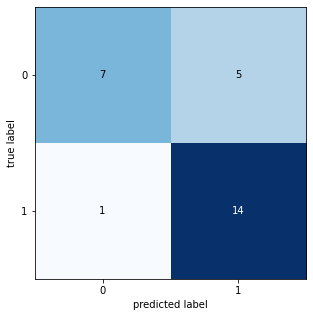

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8137931034482759
              precision    recall  f1-score   support

           0     

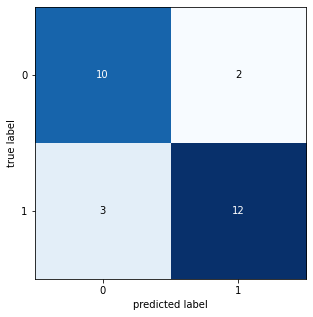

avg accuraccy Prostate Cancer =  0.874074074074074
avg F1_Score Prostate Cancer =  0.8690888345933985
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7617647058823529
Running Time:  42.30928819799965
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

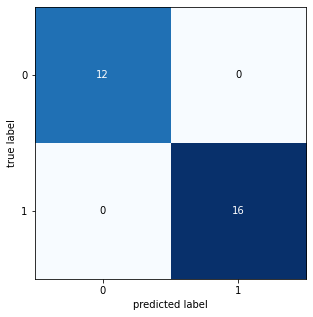

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

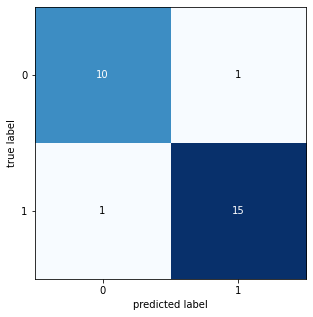

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

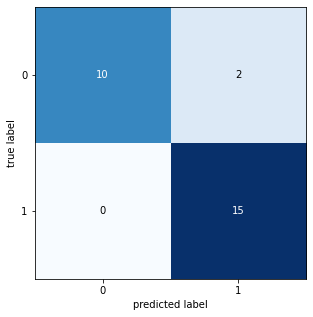

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7407407407407407
F1_Score :  0.7157894736842105
              precision    recall  f1-score   support

           0     

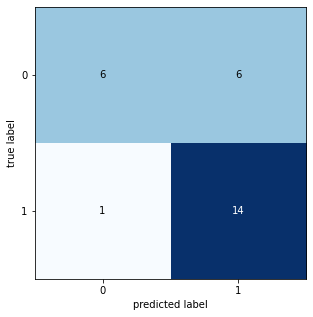

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

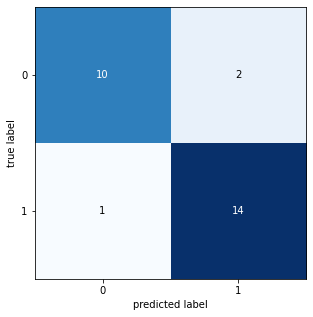

avg accuraccy Prostate Cancer =  0.8962962962962961
avg F1_Score Prostate Cancer =  0.8897551789393157
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.7407407407407407
min F1_Score Prostate Cancer =  0.7157894736842105
Running Time:  41.98303379100025
gene : [1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

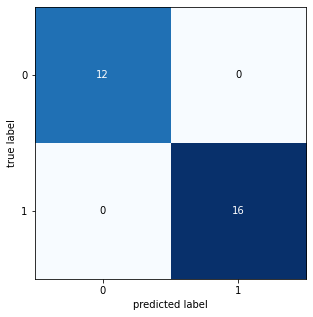

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8411764705882352
              precision    recall  f1-score   support

           0     

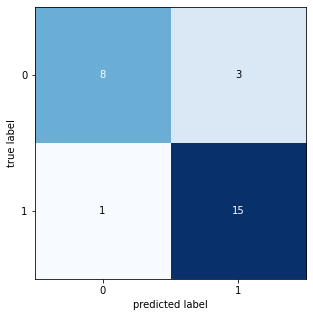

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

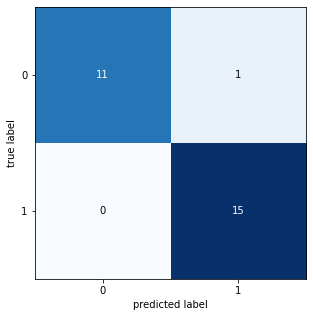

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

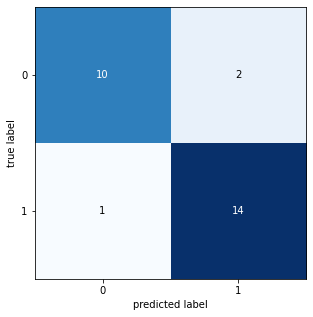

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

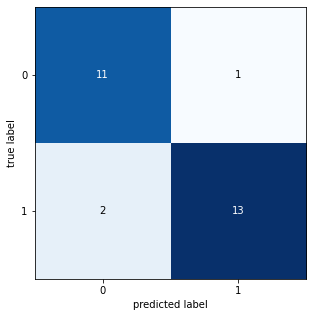

avg accuraccy Prostate Cancer =  0.9185185185185185
avg F1_Score Prostate Cancer =  0.9155959363771625
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8411764705882352
Running Time:  41.45060559900003
gene : [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

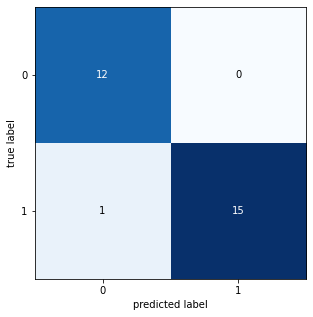

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

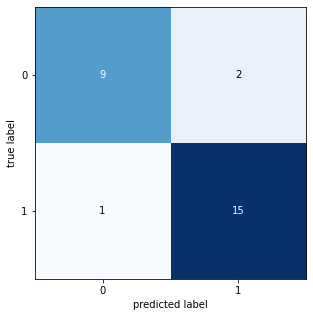

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168831
              precision    recall  f1-score   support

           0     

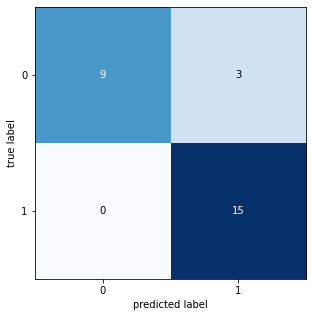

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7617647058823529
              precision    recall  f1-score   support

           0     

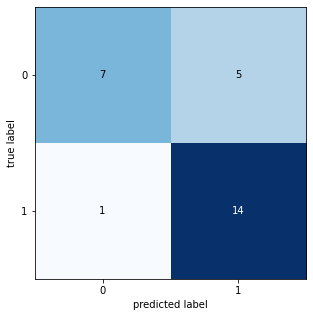

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8137931034482759
              precision    recall  f1-score   support

           0     

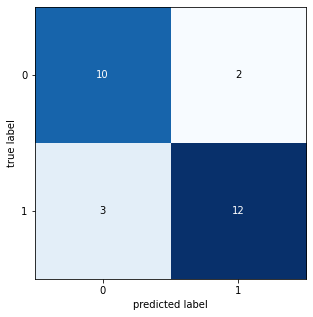

avg accuraccy Prostate Cancer =  0.8669312169312169
avg F1_Score Prostate Cancer =  0.8611325086612661
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7617647058823529
Running Time:  47.202502620999894
gene : [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

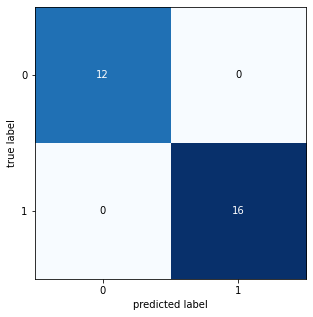

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

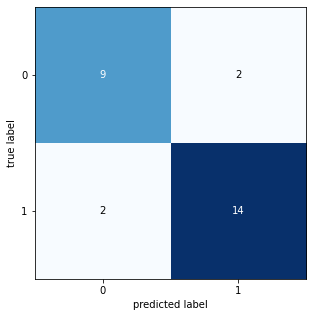

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

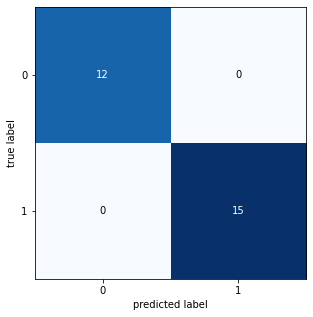

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

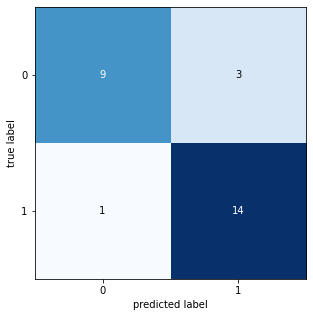

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

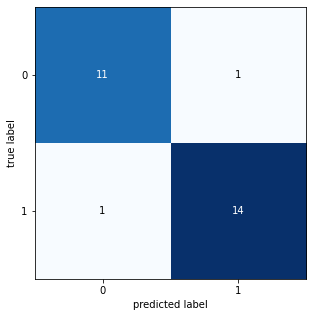

avg accuraccy Prostate Cancer =  0.9259259259259259
avg F1_Score Prostate Cancer =  0.9236363636363636
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909091
Running Time:  49.96932580099974
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

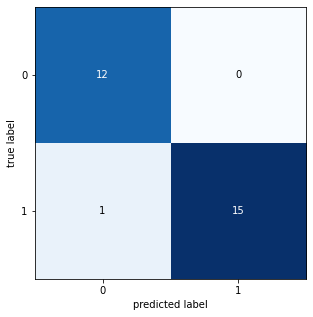

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8411764705882352
              precision    recall  f1-score   support

           0     

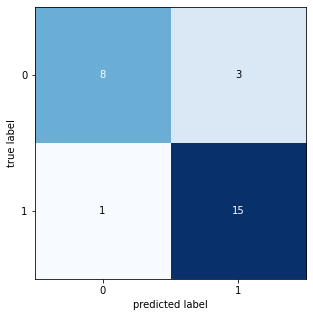

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

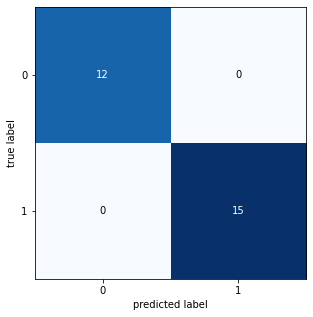

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

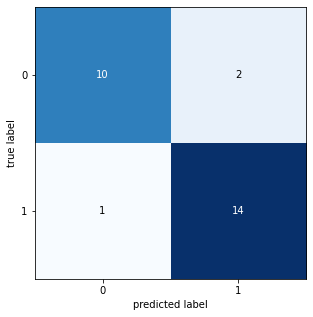

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

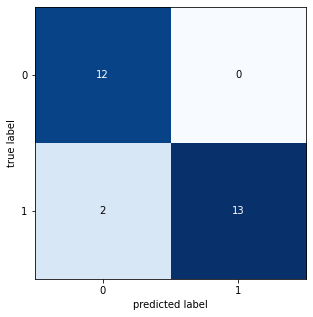

avg accuraccy Prostate Cancer =  0.9261904761904761
avg F1_Score Prostate Cancer =  0.9234534252151609
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8411764705882352
Running Time:  50.44689559800008
gene : [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

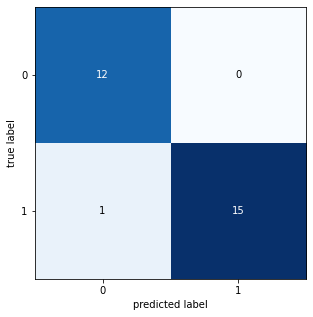

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

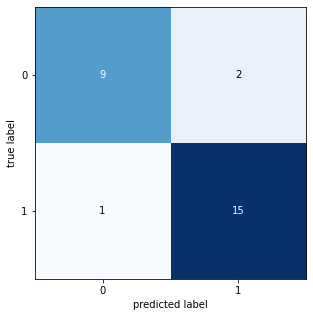

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

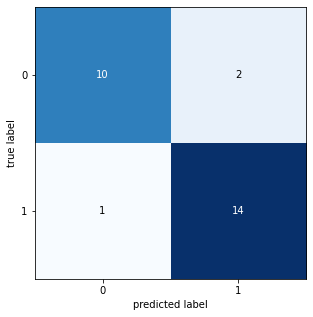

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7407407407407407
F1_Score :  0.7157894736842105
              precision    recall  f1-score   support

           0     

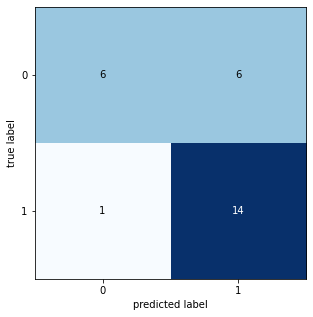

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

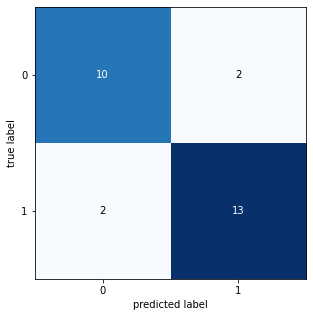

avg accuraccy Prostate Cancer =  0.8669312169312169
avg F1_Score Prostate Cancer =  0.8598345672928975
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7407407407407407
min F1_Score Prostate Cancer =  0.7157894736842105
Running Time:  46.398649549999845
gen terbaik : [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
F-1 Score terbaik : 0.9236363636363636  || Akurasi terbaik : 0.9259259259259259  || jumlah fitur : 46

Generation : 2
gene : [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 

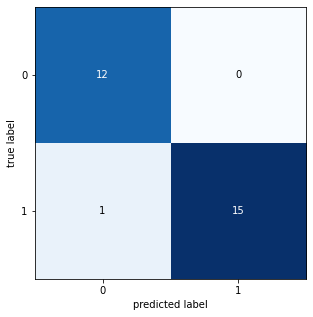

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.7777777777777778
F1_Score :  0.761764705882353
              precision    recall  f1-score   support

           0      

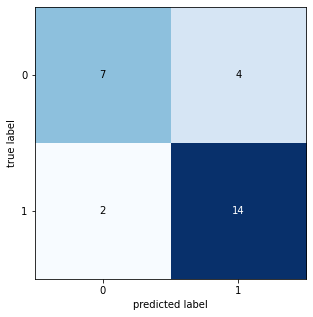

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

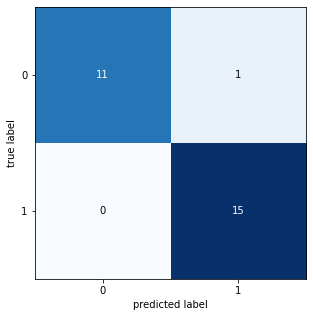

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

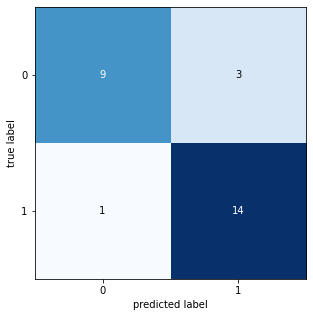

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

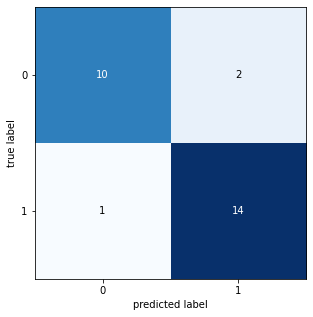

avg accuraccy Prostate Cancer =  0.8891534391534393
avg F1_Score Prostate Cancer =  0.8841507863887618
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.761764705882353
Running Time:  44.14491850700006
gene : [0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

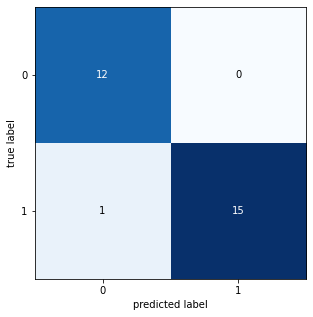

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

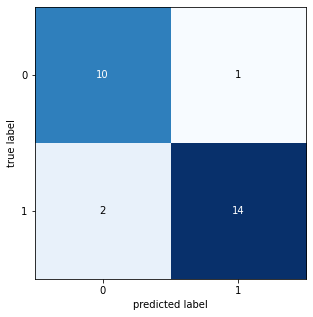

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

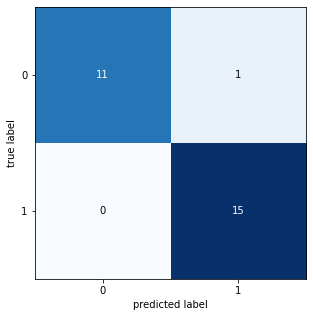

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

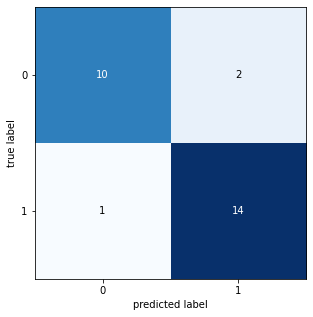

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

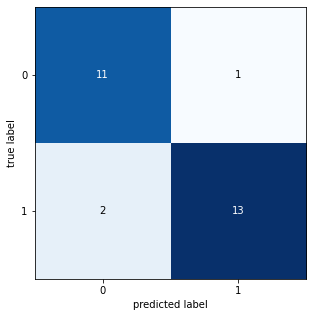

avg accuraccy Prostate Cancer =  0.9187830687830687
avg F1_Score Prostate Cancer =  0.9174139381921943
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8863955119214586
Running Time:  45.784891231000074
gene : [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

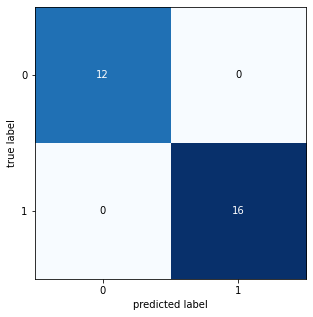

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

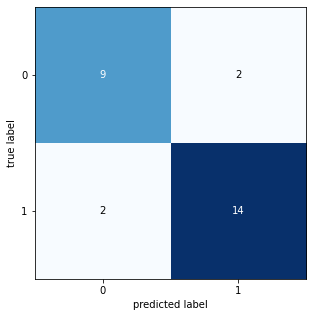

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

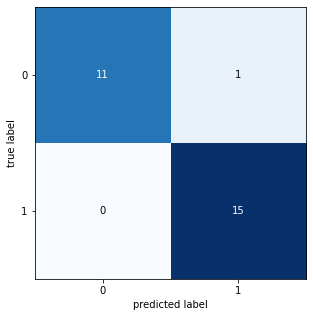

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

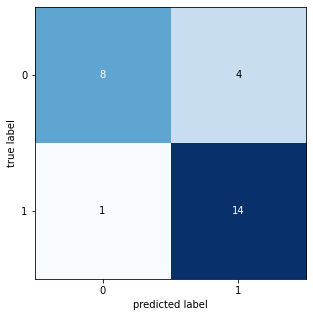

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

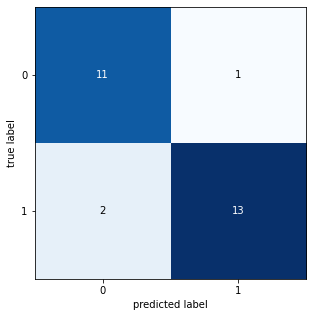

avg accuraccy Prostate Cancer =  0.9037037037037038
avg F1_Score Prostate Cancer =  0.9004386827323666
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  43.080905121999876
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

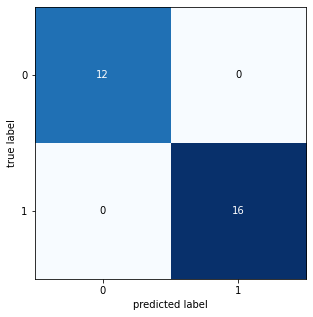

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

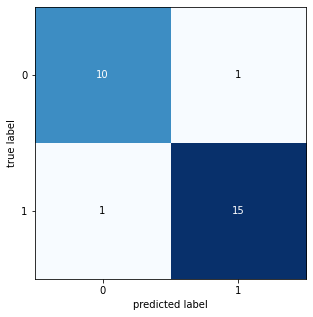

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

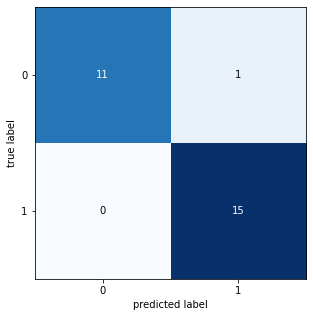

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8137931034482759
              precision    recall  f1-score   support

           0     

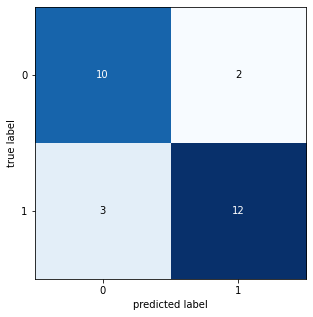

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.888888888888889
              precision    recall  f1-score   support

           0      

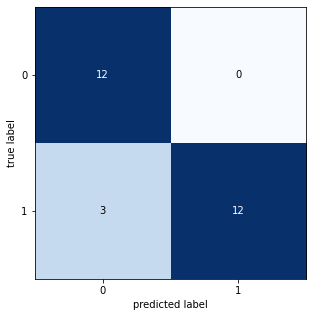

avg accuraccy Prostate Cancer =  0.9185185185185185
avg F1_Score Prostate Cancer =  0.9176218568379545
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8137931034482759
Running Time:  42.6595413
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114 115 1

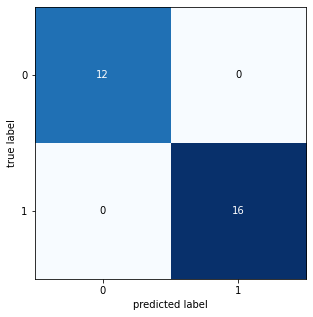

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

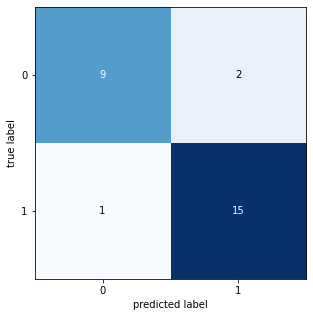

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

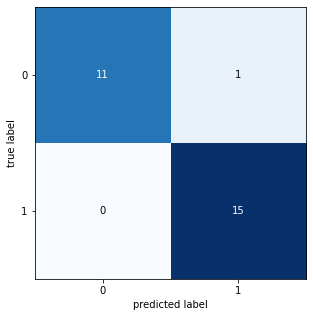

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

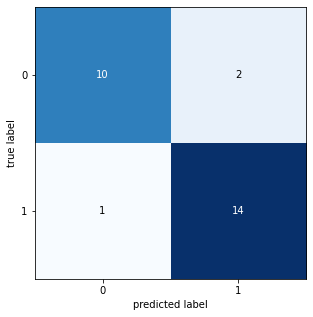

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

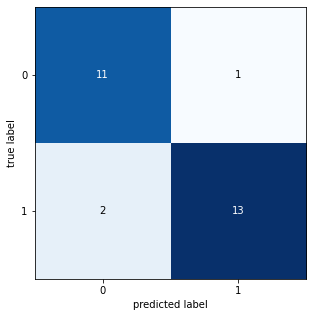

avg accuraccy Prostate Cancer =  0.9259259259259259
avg F1_Score Prostate Cancer =  0.9239840188828922
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8831168831168832
Running Time:  42.89096123699983
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

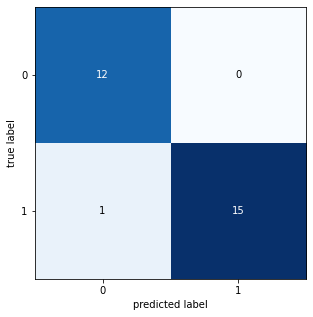

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

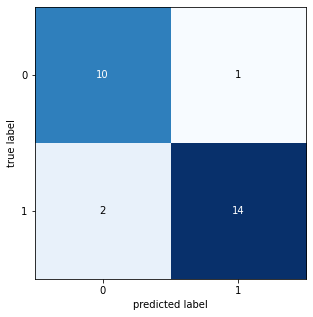

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

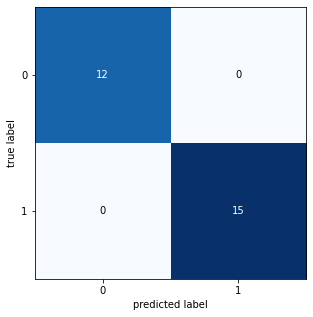

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

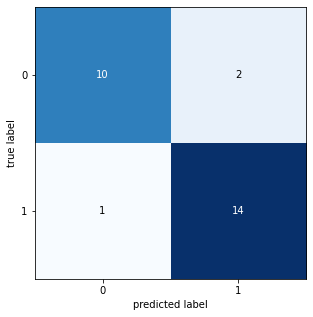

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

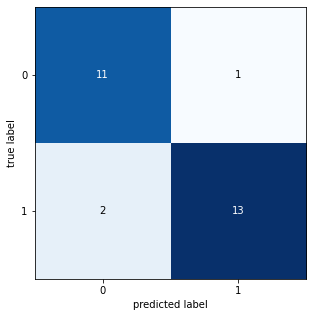

avg accuraccy Prostate Cancer =  0.9261904761904762
avg F1_Score Prostate Cancer =  0.9249875707307635
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8863955119214586
Running Time:  47.179956219999895
gene : [1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

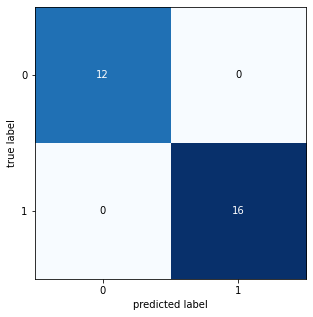

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

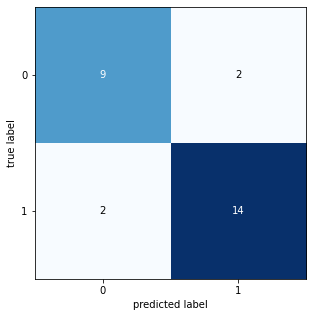

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

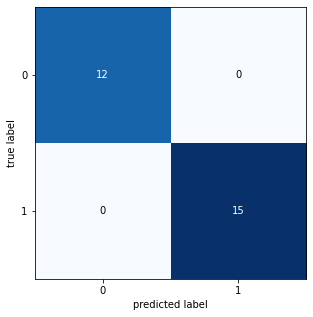

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

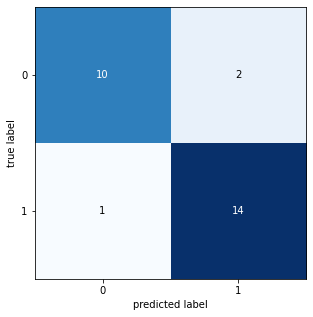

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8137931034482759
              precision    recall  f1-score   support

           0     

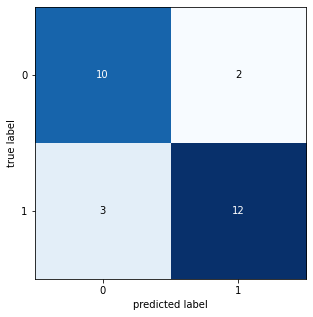

avg accuraccy Prostate Cancer =  0.9111111111111111
avg F1_Score Prostate Cancer =  0.9093559048921287
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8137931034482759
Running Time:  48.373236610000276
gene : [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

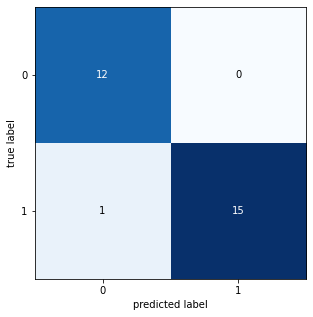

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

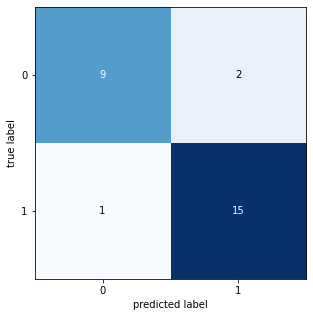

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

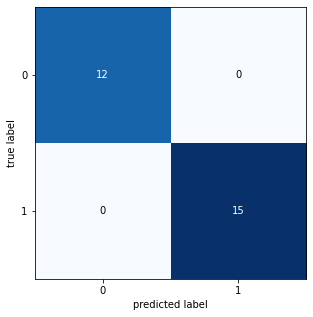

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

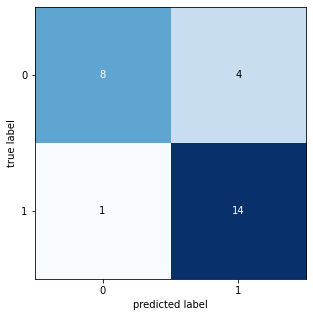

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

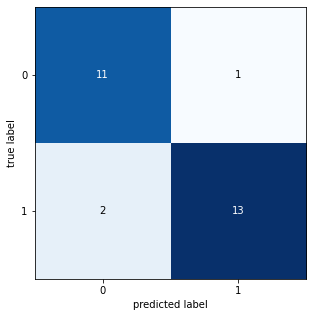

avg accuraccy Prostate Cancer =  0.9113756613756614
avg F1_Score Prostate Cancer =  0.9080917036245179
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  47.30950456200026
gene : [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

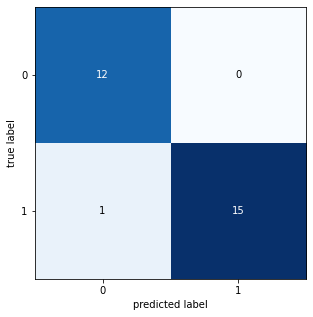

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

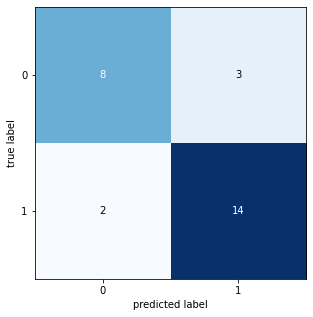

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

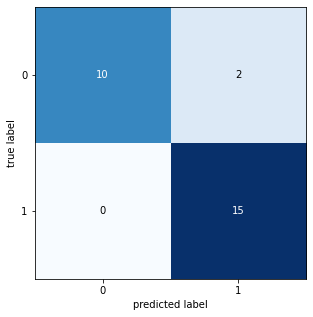

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

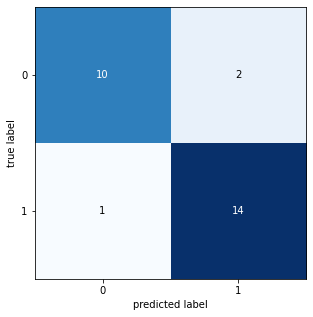

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

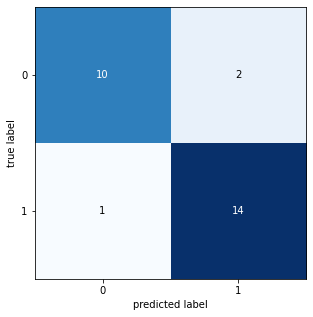

avg accuraccy Prostate Cancer =  0.8965608465608466
avg F1_Score Prostate Cancer =  0.8930304502650225
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  49.12001452599998
gene : [1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

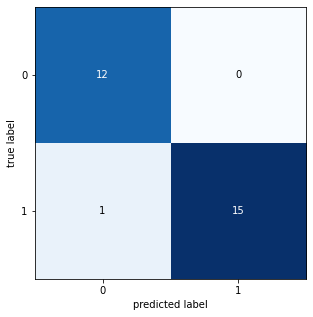

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8148148148148148
F1_Score :  0.7969924812030076
              precision    recall  f1-score   support

           0     

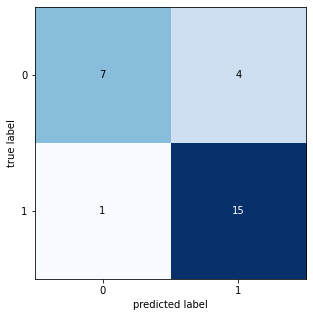

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

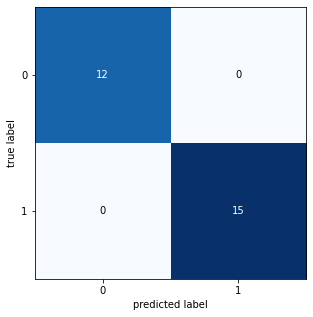

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

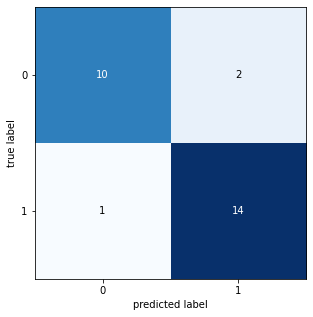

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

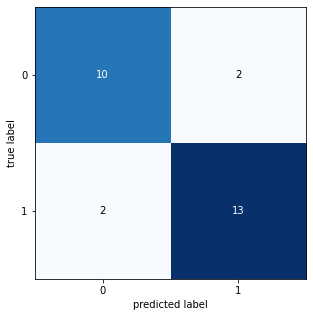

avg accuraccy Prostate Cancer =  0.903968253968254
avg F1_Score Prostate Cancer =  0.8994517921732804
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.7969924812030076
Running Time:  49.201516171000094
gen terbaik : [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
F-1 Score terbaik : 0.9249875707307635  || Akurasi terbaik : 0.9261904761904762  || jumlah fitur : 50

Generation : 3
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1

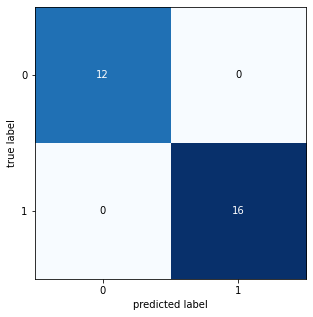

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8781954887218045
              precision    recall  f1-score   support

           0     

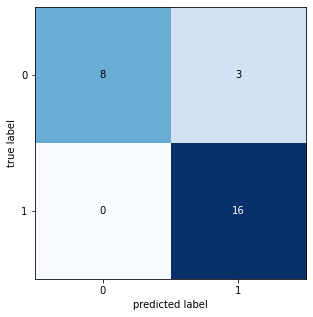

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

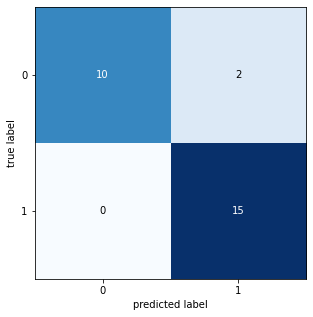

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

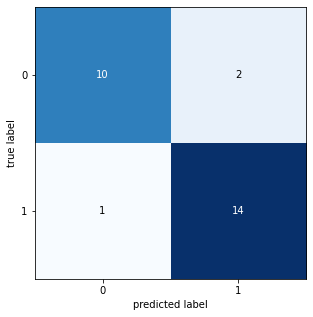

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.92      0

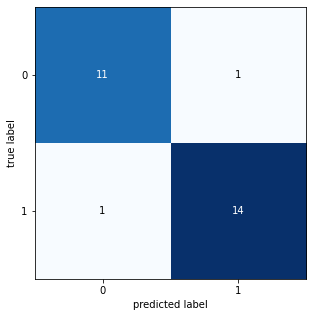

avg accuraccy Prostate Cancer =  0.9259259259259259
avg F1_Score Prostate Cancer =  0.9225772910377434
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8781954887218045
Running Time:  53.34632532000023
gene : [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

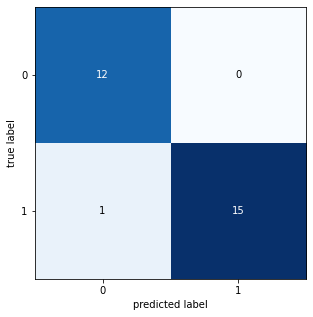

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8499999999999999
              precision    recall  f1-score   support

           0     

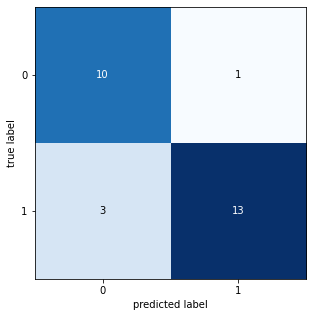

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

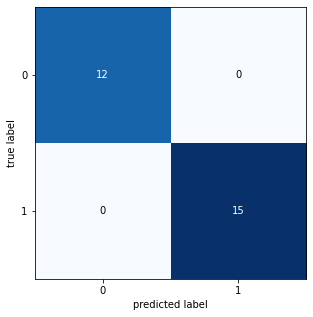

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8137931034482759
              precision    recall  f1-score   support

           0     

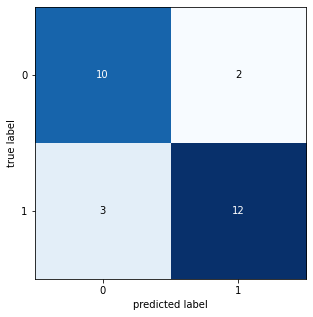

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8516483516483516
              precision    recall  f1-score   support

           0     

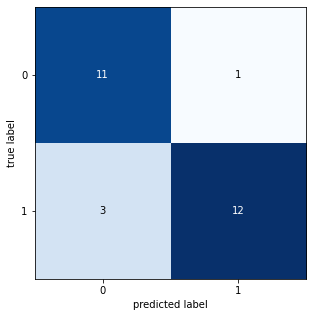

avg accuraccy Prostate Cancer =  0.8965608465608466
avg F1_Score Prostate Cancer =  0.8958624845677126
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8137931034482759
Running Time:  55.221168557000055
gene : [1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 1

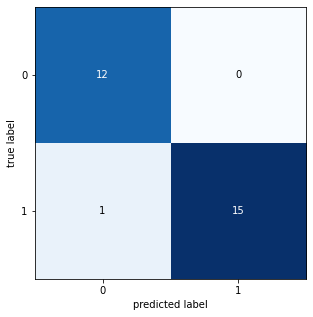

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

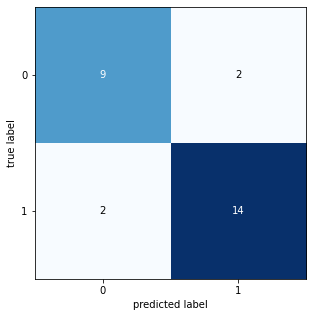

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

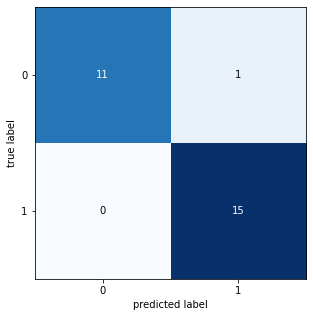

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

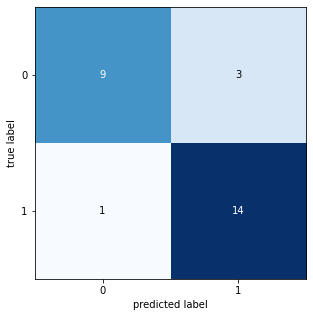

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

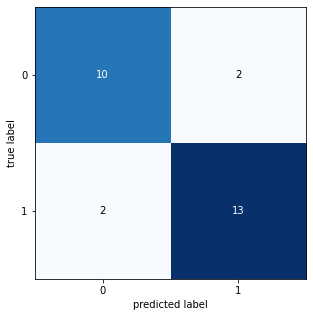

avg accuraccy Prostate Cancer =  0.8965608465608466
avg F1_Score Prostate Cancer =  0.8938369246461815
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909091
Running Time:  50.22671700000001
gene : [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

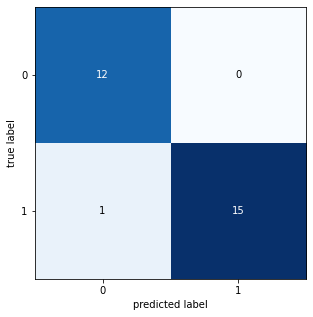

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

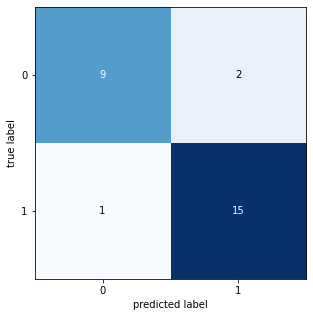

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

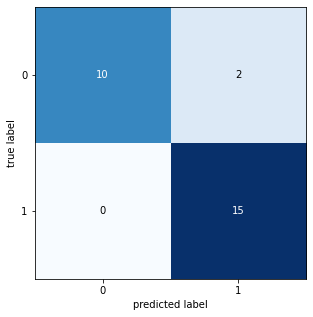

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

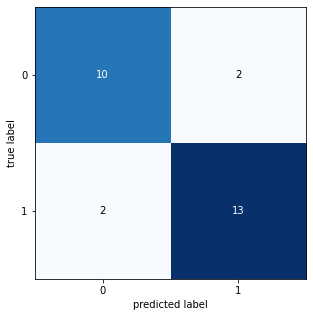

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

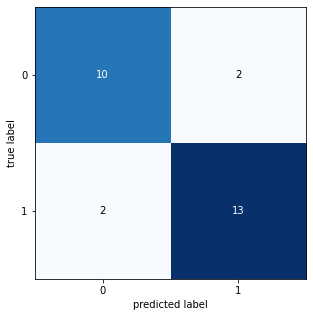

avg accuraccy Prostate Cancer =  0.8965608465608467
avg F1_Score Prostate Cancer =  0.8940566610808547
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8500000000000001
Running Time:  59.5566800419997
gene : [1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

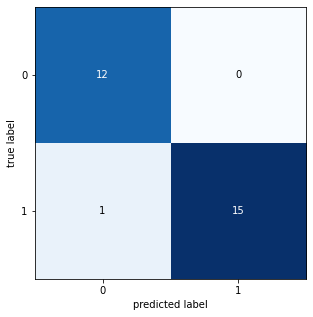

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

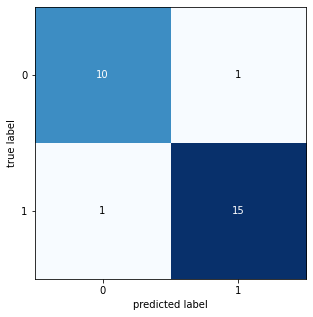

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168831
              precision    recall  f1-score   support

           0     

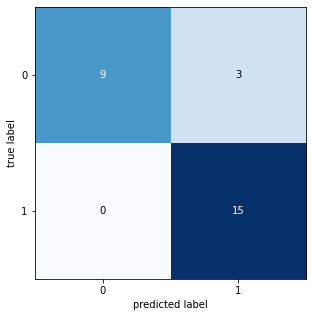

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

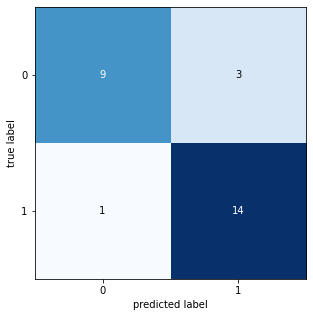

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

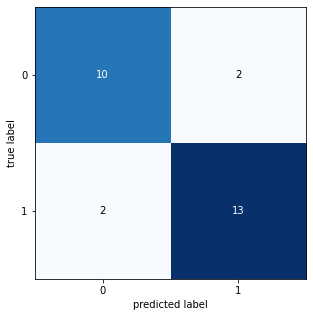

avg accuraccy Prostate Cancer =  0.8965608465608467
avg F1_Score Prostate Cancer =  0.8933748428990365
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909091
Running Time:  61.561563061000015
gene : [1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 

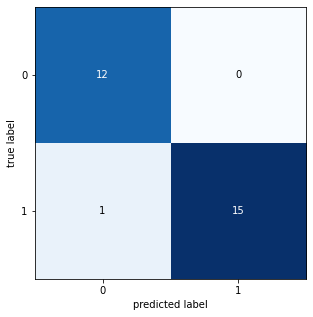

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8499999999999999
              precision    recall  f1-score   support

           0     

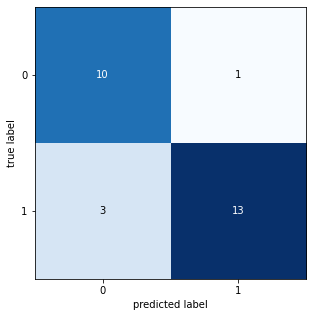

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

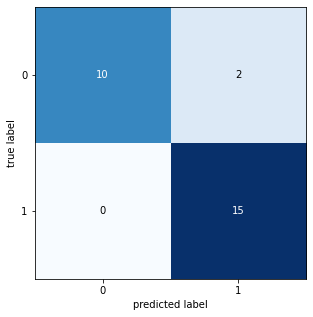

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

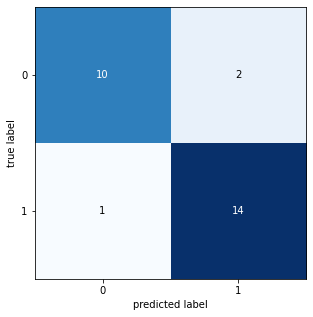

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

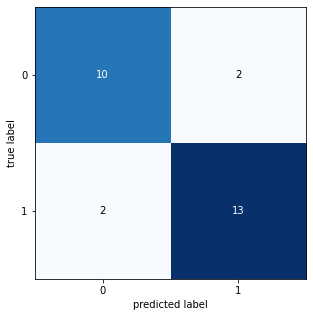

avg accuraccy Prostate Cancer =  0.8965608465608466
avg F1_Score Prostate Cancer =  0.8947123868417698
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8499999999999999
Running Time:  59.07465226400018
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

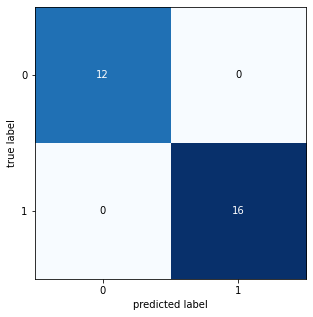

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

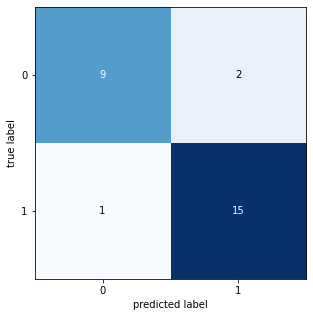

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9627586206896552
              precision    recall  f1-score   support

           0     

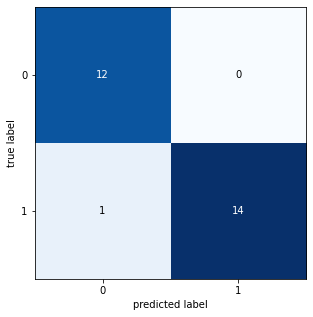

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

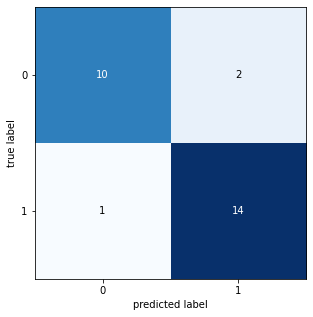

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

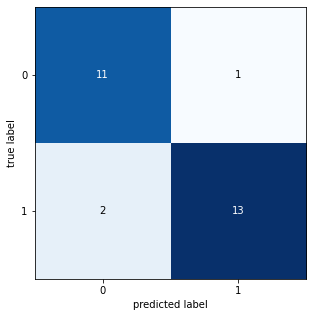

avg accuraccy Prostate Cancer =  0.9259259259259259
avg F1_Score Prostate Cancer =  0.9241093755593924
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8888888888888888
min F1_Score Prostate Cancer =  0.8831168831168832
Running Time:  57.18572726100001
gene : [1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

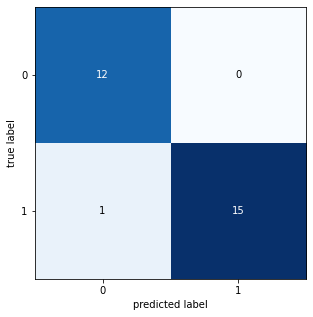

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

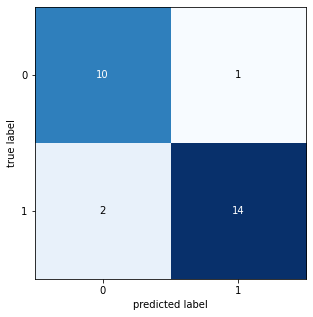

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

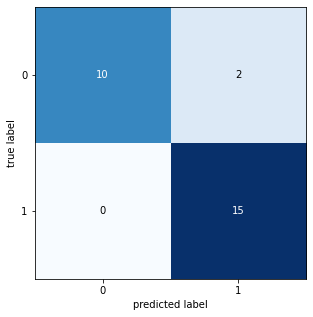

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

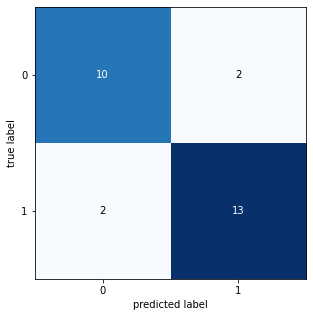

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

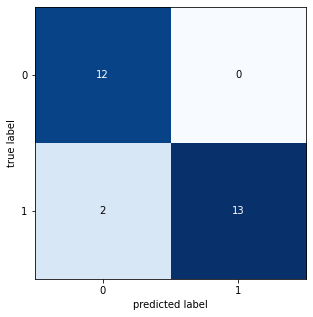

avg accuraccy Prostate Cancer =  0.9113756613756614
avg F1_Score Prostate Cancer =  0.9098772220066049
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8500000000000001
Running Time:  57.41439817399987
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

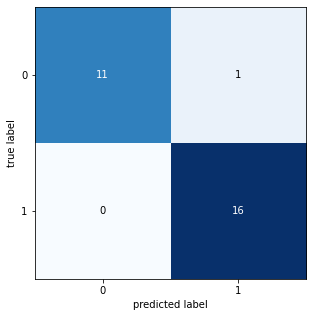

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

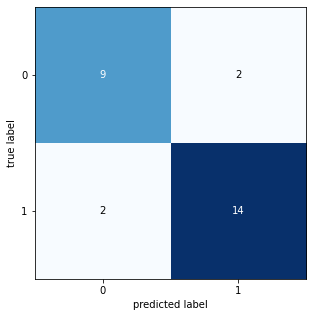

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

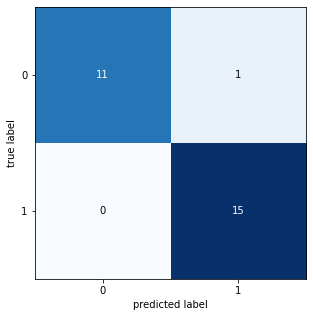

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

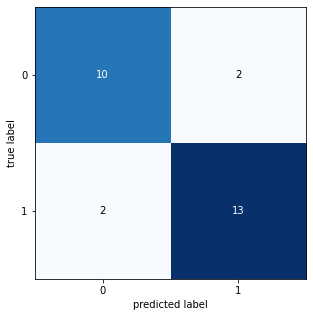

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

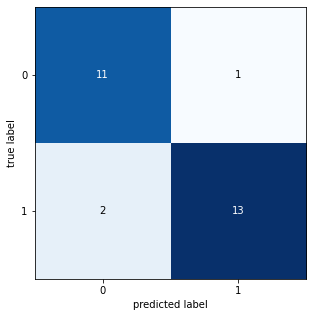

avg accuraccy Prostate Cancer =  0.9039682539682538
avg F1_Score Prostate Cancer =  0.9020215925761459
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9631093544137023
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909092
Running Time:  66.90218883399984
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

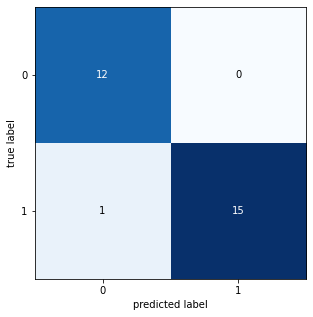

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

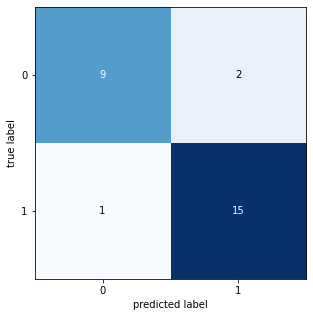

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9627586206896552
              precision    recall  f1-score   support

           0     

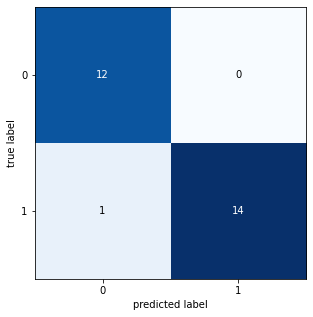

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

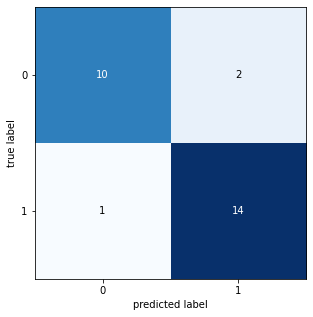

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8137931034482759
              precision    recall  f1-score   support

           0     

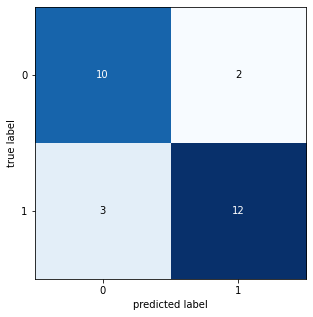

avg accuraccy Prostate Cancer =  0.903968253968254
avg F1_Score Prostate Cancer =  0.9019870173836416
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8137931034482759
Running Time:  67.89667022599997
gen terbaik : [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
F-1 Score terbaik : 0.9249875707307635  || Akurasi terbaik : 0.9261904761904762  || jumlah fitur : 50

Generation : 4
gene : [1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,

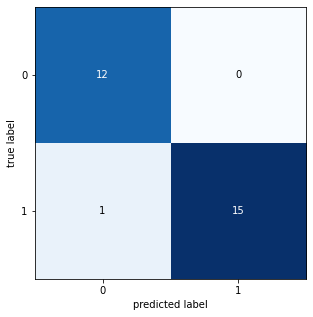

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

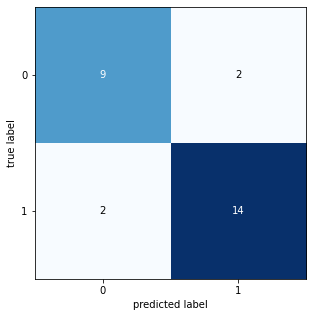

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

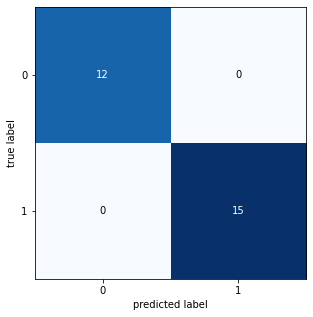

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

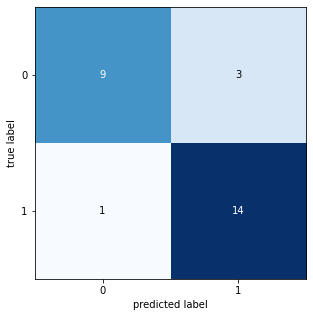

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9258241758241759
              precision    recall  f1-score   support

           0     

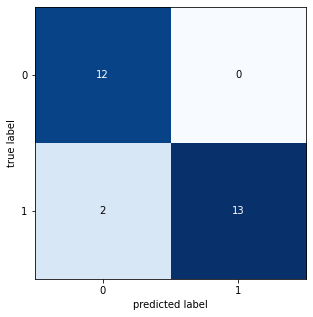

avg accuraccy Prostate Cancer =  0.9187830687830687
avg F1_Score Prostate Cancer =  0.916575392349586
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909091
Running Time:  58.72561160399982
gene : [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

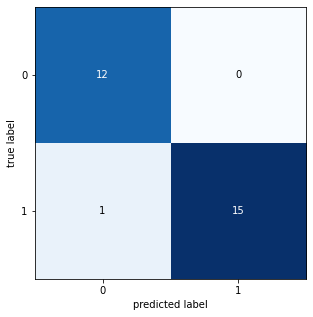

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

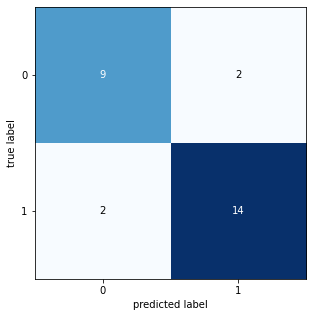

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

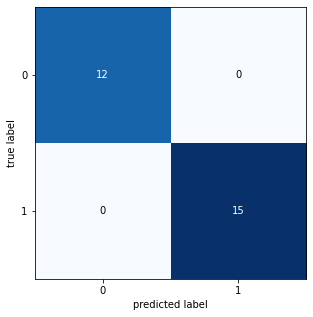

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

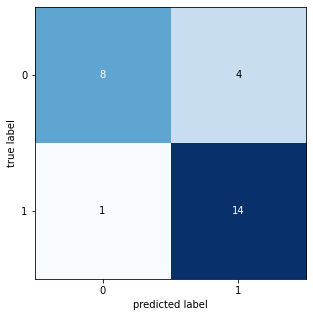

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

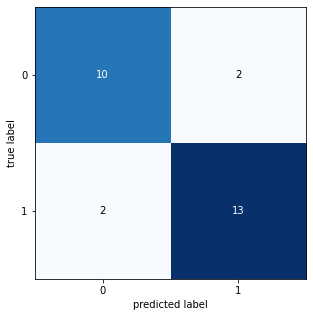

avg accuraccy Prostate Cancer =  0.8965608465608466
avg F1_Score Prostate Cancer =  0.8931313364055299
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  59.45829010600028
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

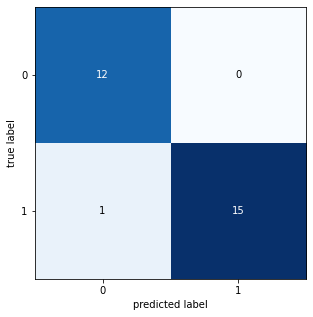

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8411764705882352
              precision    recall  f1-score   support

           0     

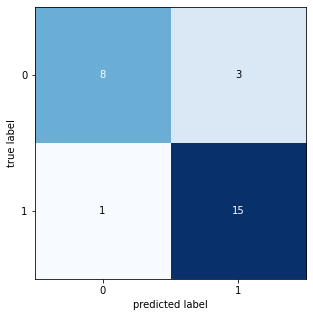

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168831
              precision    recall  f1-score   support

           0     

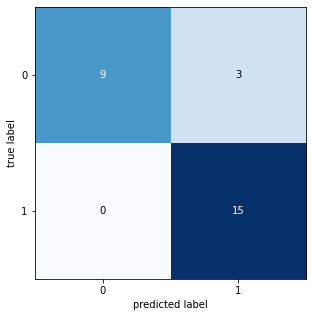

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

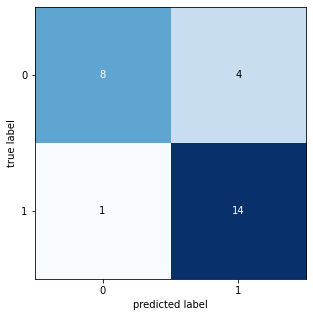

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

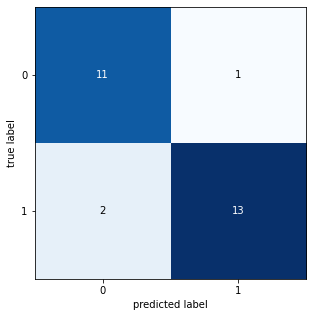

avg accuraccy Prostate Cancer =  0.8817460317460316
avg F1_Score Prostate Cancer =  0.8763269977421648
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9638709677419355
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  59.86884725200025
gene : [1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 1

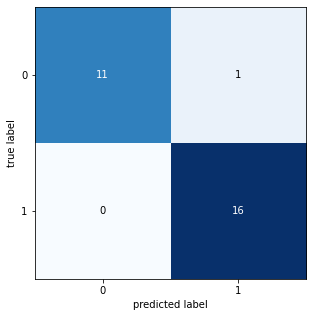

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

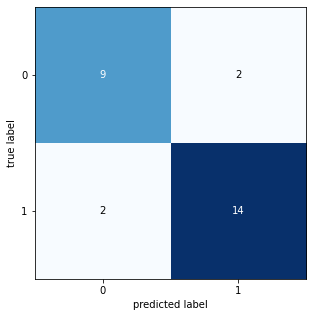

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

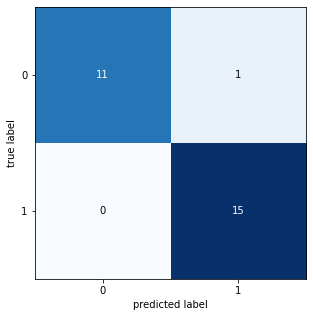

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7777777777777778
F1_Score :  0.7698863636363635
              precision    recall  f1-score   support

           0     

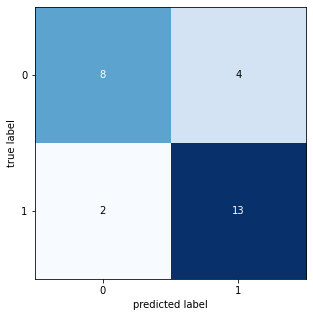

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

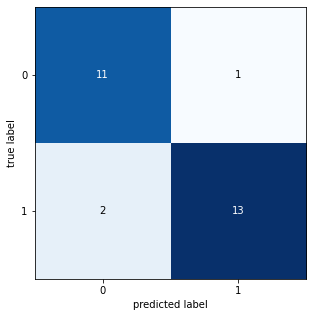

avg accuraccy Prostate Cancer =  0.889153439153439
avg F1_Score Prostate Cancer =  0.8859988653034186
max accuraccy Prostate Cancer =  0.9642857142857143
max F1_Score Prostate Cancer =  0.9631093544137023
min accuraccy Prostate Cancer =  0.7777777777777778
min F1_Score Prostate Cancer =  0.7698863636363635
Running Time:  62.47800476100019
gene : [1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 10

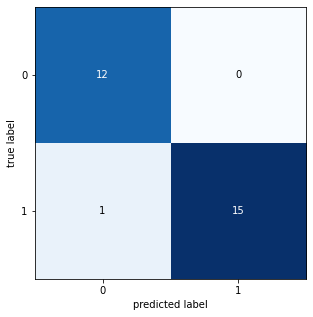

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

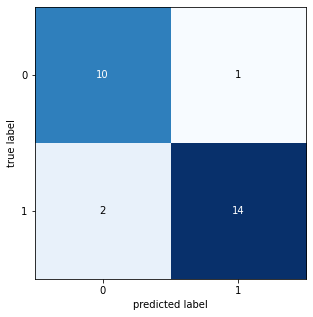

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

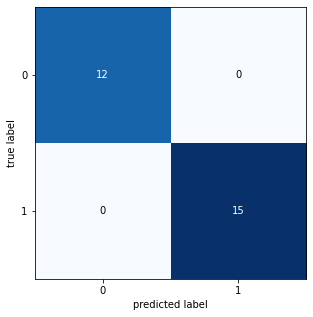

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909091
              precision    recall  f1-score   support

           0     

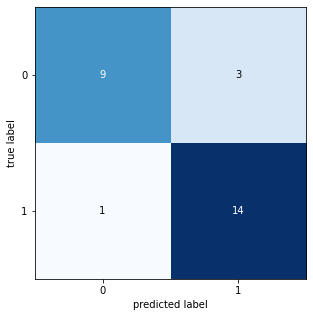

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

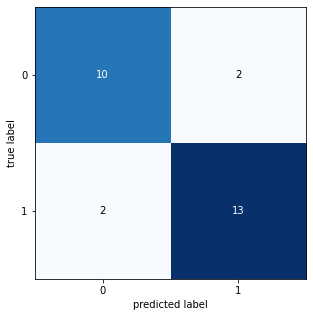

avg accuraccy Prostate Cancer =  0.9113756613756614
avg F1_Score Prostate Cancer =  0.9093714777508606
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909091
Running Time:  59.20265200199992
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

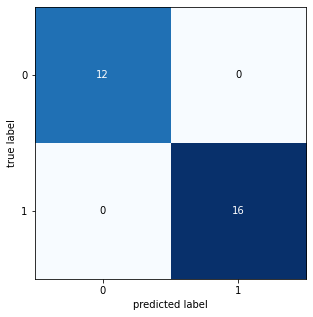

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8831168831168832
              precision    recall  f1-score   support

           0     

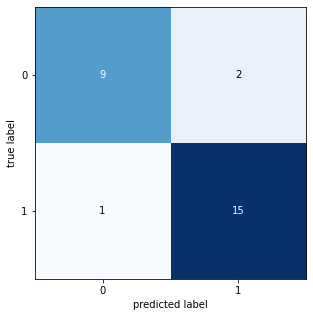

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9621318373071529
              precision    recall  f1-score   support

           0     

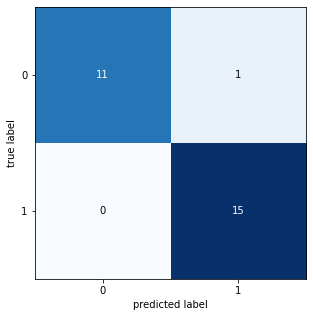

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.7407407407407407
F1_Score :  0.7157894736842105
              precision    recall  f1-score   support

           0     

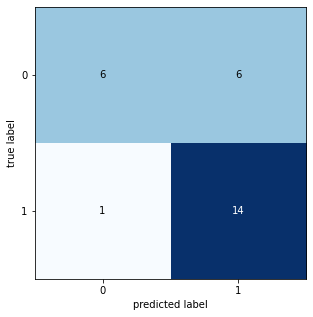

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

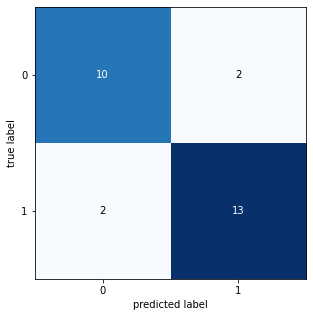

avg accuraccy Prostate Cancer =  0.888888888888889
avg F1_Score Prostate Cancer =  0.8822076388216494
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.7407407407407407
min F1_Score Prostate Cancer =  0.7157894736842105
Running Time:  57.582608172000164
gene : [0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 11

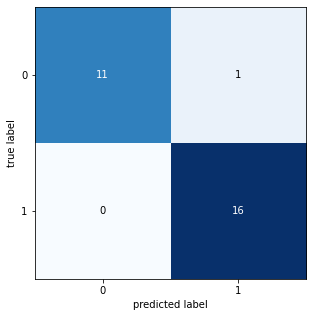

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8148148148148148
F1_Score :  0.8051948051948052
              precision    recall  f1-score   support

           0     

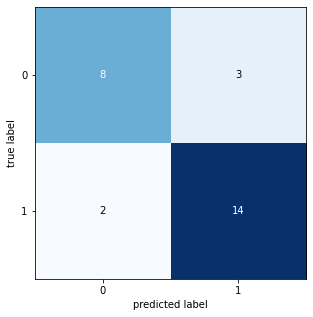

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

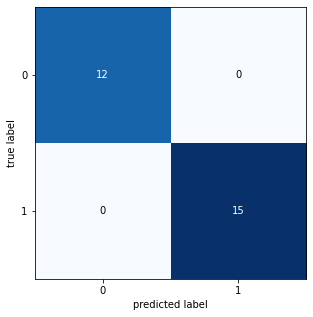

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

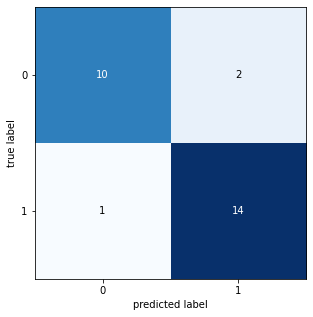

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

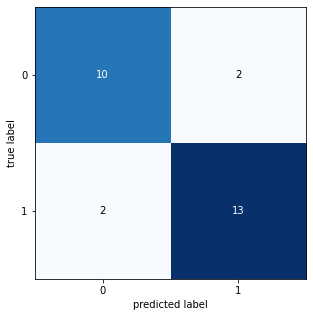

avg accuraccy Prostate Cancer =  0.903968253968254
avg F1_Score Prostate Cancer =  0.9009399343059933
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8148148148148148
min F1_Score Prostate Cancer =  0.8051948051948052
Running Time:  54.47610666000037
gene : [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

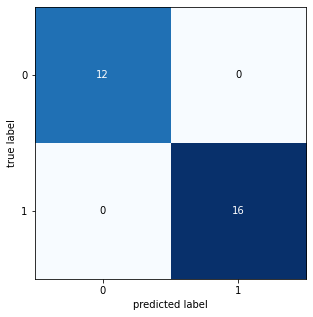

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.9232954545454546
              precision    recall  f1-score   support

           0     

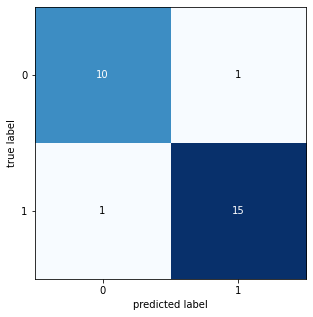

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  0.9629629629629629
F1_Score :  0.9627586206896552
              precision    recall  f1-score   support

           0     

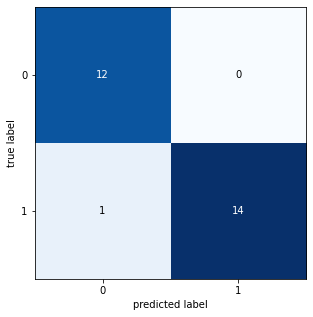

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8500000000000001
              precision    recall  f1-score   support

           0     

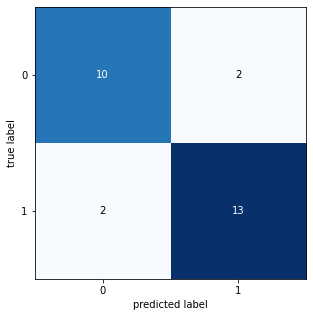

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

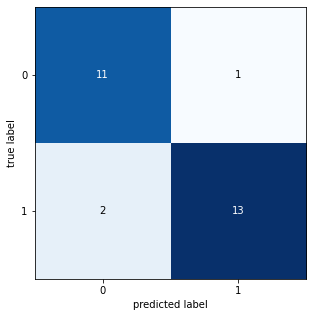

avg accuraccy Prostate Cancer =  0.9259259259259259
avg F1_Score Prostate Cancer =  0.9248659874608152
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8500000000000001
Running Time:  44.0927053180003
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

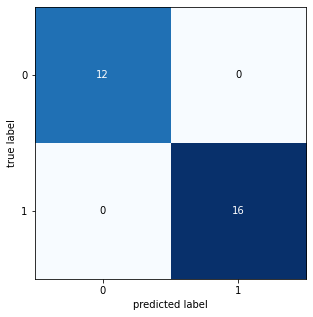

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.9259259259259259
F1_Score :  0.925
              precision    recall  f1-score   support

           0       0.85      1

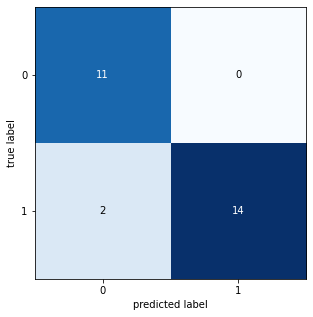

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

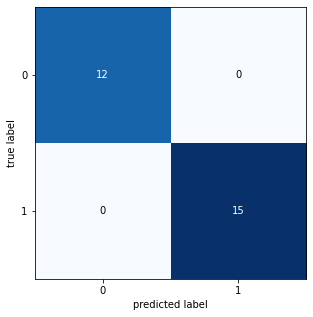

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

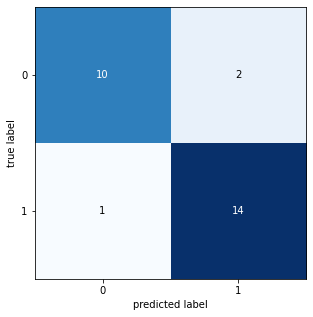

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8516483516483516
              precision    recall  f1-score   support

           0     

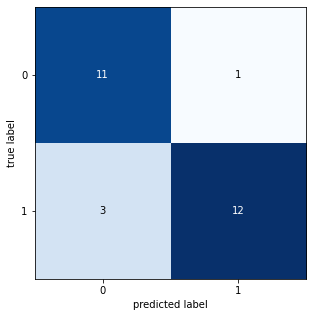

avg accuraccy Prostate Cancer =  0.9333333333333333
avg F1_Score Prostate Cancer =  0.9326087727139619
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8516483516483516
Running Time:  44.3356552109999
gene : [1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1]
Train : [  0   2   3   4   5   6   7   8  11  12  13  15  16  17  18  19  20  21
  22  23  24  26  27  28  29  30  31  33  34  35  36  37  38  39  40  41
  42  43  46  47  48  49  50  51  56  57  58  60  61  64  65  67  68  69
  70  71  72  73  74  75  76  77  79  80  81  82  83  84  85  86  87  88
  89  90  92  93  95  97  98  99 100 101 102 103 104 107 108 109 111 112
 113 114

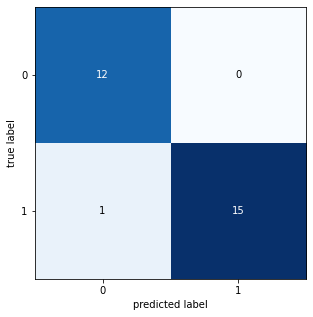

Train : [  0   1   2   5   6   8   9  10  11  12  14  15  16  17  18  19  20  21
  23  24  25  26  27  28  29  30  32  33  34  35  37  38  39  42  44  45
  46  47  50  51  52  53  54  55  56  58  59  61  62  63  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  83  85  87  90  91  92
  94  95  96  97  98  99 100 101 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 118 119 120 121 124 125 126 127 128 129 130 132 133 134
 135] Test : [  3   4   7  13  22  31  36  40  41  43  48  49  57  60  71  72  82  84
  86  88  89  93 102 117 122 123 131]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0]
Akurasi :  0.8518518518518519
F1_Score :  0.8465909090909092
              precision    recall  f1-score   support

           0     

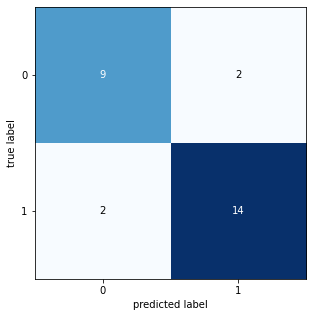

Train : [  0   1   3   4   7   9  10  12  13  14  15  17  21  22  25  27  28  29
  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  62  63  64  65  66
  69  71  72  74  75  76  77  78  79  81  82  83  84  85  86  87  88  89
  91  93  94  95  96  98  99 101 102 103 104 105 106 107 108 109 110 111
 112 114 115 116 117 120 121 122 123 124 125 126 127 128 129 130 131 132
 133] Test : [  2   5   6   8  11  16  18  19  20  23  24  26  61  67  68  70  73  80
  90  92  97 100 113 118 119 134 135]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0]
Akurasi :  1.0
F1_Score :  1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    

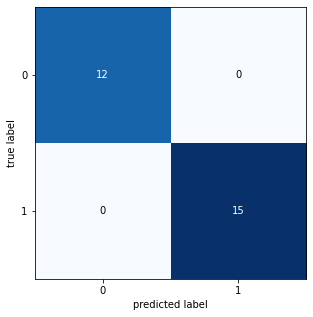

Train : [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  16  17  18
  19  20  22  23  24  25  26  27  28  29  30  31  32  34  36  39  40  41
  43  44  45  48  49  50  52  53  54  55  56  57  59  60  61  62  63  64
  66  67  68  70  71  72  73  74  76  77  78  79  80  81  82  84  85  86
  88  89  90  91  92  93  94  96  97  98  99 100 102 105 106 107 110 111
 112 113 114 116 117 118 119 120 121 122 123 124 125 126 131 132 133 134
 135] Test : [ 15  21  33  35  37  38  42  46  47  51  58  65  69  75  83  87  95 101
 103 104 108 109 115 127 128 129 130]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8863955119214586
              precision    recall  f1-score   support

           0     

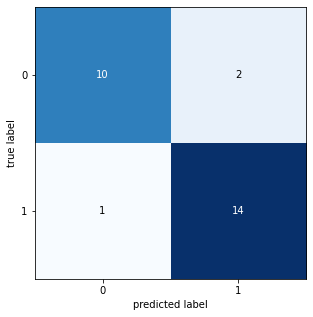

Train : [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
  21  22  23  24  25  26  31  32  33  35  36  37  38  40  41  42  43  44
  45  46  47  48  49  51  52  53  54  55  57  58  59  60  61  62  63  65
  66  67  68  69  70  71  72  73  75  78  80  82  83  84  86  87  88  89
  90  91  92  93  94  95  96  97 100 101 102 103 104 105 106 108 109 110
 113 115 116 117 118 119 120 121 122 123 125 126 127 128 129 130 131 134
 135] Test : [  0  12  17  27  28  29  30  34  39  50  56  64  74  76  77  79  81  85
  98  99 107 111 112 114 124 132 133]
Y_Train : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Y_Test : [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0]
Akurasi :  0.8888888888888888
F1_Score :  0.8882758620689655
              precision    recall  f1-score   support

           0     

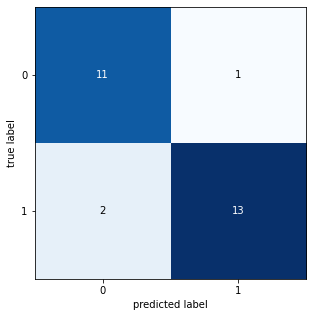

avg accuraccy Prostate Cancer =  0.9187830687830687
avg F1_Score Prostate Cancer =  0.9170266501646538
max accuraccy Prostate Cancer =  1.0
max F1_Score Prostate Cancer =  1.0
min accuraccy Prostate Cancer =  0.8518518518518519
min F1_Score Prostate Cancer =  0.8465909090909092
Running Time:  40.96309851700062
gen terbaik : [1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1]
F-1 Score terbaik : 0.9326087727139619  || Akurasi terbaik : 0.9333333333333333  || jumlah fitur : 50

Running Time:  2482.9836221530004


In [15]:
Prostate_IG_GA = GeneticAlgorithm(Prostate_IG, 4)